In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12197.78it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [3]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [4]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
                    obs_seq = torch.stack(episode_seq + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t_encoded, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")

    return buf, rewards, episode_rewards

In [5]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=47.0585, Policy=0.0047, Value=94.1993
[PPO] Epoch 10: Loss=43.0362, Policy=0.0118, Value=86.1554
[PPO] Epoch 20: Loss=37.9314, Policy=-0.0110, Value=75.9817
[PPO] Epoch 30: Loss=32.4989, Policy=-0.0088, Value=65.1181
Approx KL Learned: 0.015316257253289223
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=53.7406, Policy=-0.0002, Value=107.5775
[PPO] Epoch 10: Loss=48.3108, Policy=-0.0080, Value=96.7360
[PPO] Epoch 20: Loss=44.3192, Policy=-0.0063, Value=88.7536
[PPO] Epoch 30: Loss=40.6079, Policy=-0.0097, Value=81.3362
Approx KL Learned: 0.010913150385022163
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=53.7928, Policy=0.0033, Value=107.6792
[PPO] Epoch 10: Loss=44.3999, Policy=-0.0025, Value=88.9099
[PPO] Epoch 20: Loss=40.6516, Policy=-0.0074, Value=81.4217
[PPO] Epoch 30: Loss=37.4048, Policy=-0.0076, Value=74.9290
Approx KL Learned: 0.018538590520620346
[✅] Actor-Critic che

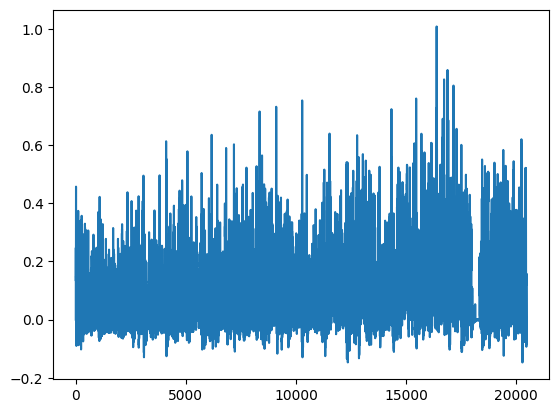

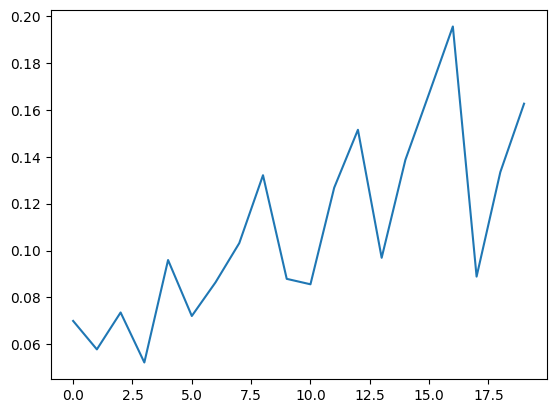

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=77.9719, Policy=0.0009, Value=156.0461
[PPO] Epoch 10: Loss=44.9229, Policy=-0.0093, Value=89.9697
[PPO] Epoch 20: Loss=35.9497, Policy=-0.0134, Value=72.0316
[PPO] Epoch 30: Loss=31.0480, Policy=-0.0183, Value=62.2377
Approx KL Learned: 0.018358809873461723
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=101.8393, Policy=0.0047, Value=203.7762
[PPO] Epoch 10: Loss=79.2328, Policy=-0.0002, Value=158.5720
[PPO] Epoch 20: Loss=68.5319, Policy=-0.0039, Value=137.1780
[PPO] Epoch 30: Loss=63.2445, Policy=-0.0079, Value=126.6113
Approx KL Learned: 0.013501312583684921
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=84.1570, Policy=0.0012, Value=168.4169
[PPO] Epoch 10: Loss=65.8923, Policy=-0.0063, Value=131.9010
[PPO] Epoch 20: Loss=58.2441, Policy=-0.0107, Value=116.6143
[PPO] Epoch 30: Loss=52.6308, Policy=-0.0179, Value=105.4011
Approx KL Learned: 0.026321494951844215
[✅] Actor-Cr

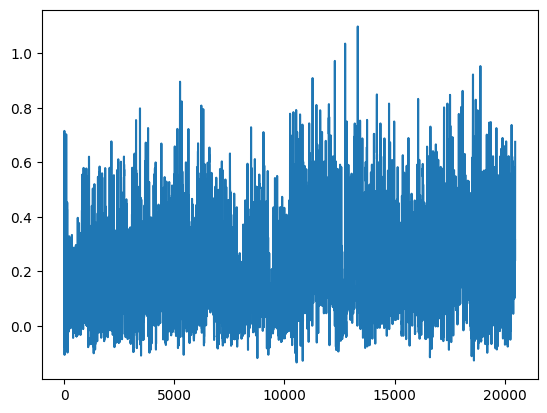

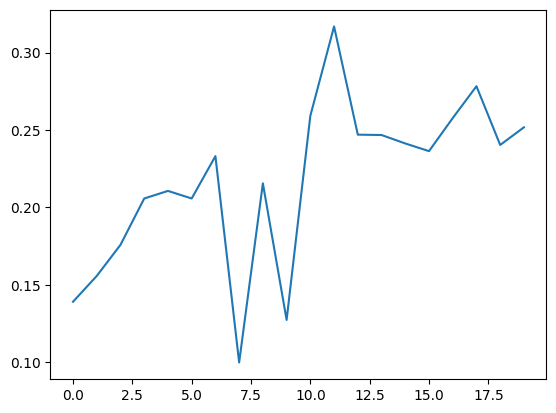

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=56.1771, Policy=0.0076, Value=112.4383
[PPO] Epoch 10: Loss=43.8845, Policy=0.0102, Value=87.8453
[PPO] Epoch 20: Loss=37.0456, Policy=-0.0013, Value=74.1941
[PPO] Epoch 30: Loss=31.6867, Policy=-0.0003, Value=63.4765
Approx KL Learned: 0.05153457447886467
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=57.8354, Policy=0.0012, Value=115.7583
[PPO] Epoch 10: Loss=45.4033, Policy=-0.0190, Value=90.9333
[PPO] Epoch 20: Loss=37.7304, Policy=-0.0190, Value=75.5903
[PPO] Epoch 30: Loss=30.2994, Policy=-0.0248, Value=60.7375
Approx KL Learned: 0.01683867536485195
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=55.1642, Policy=0.0023, Value=110.4142
[PPO] Epoch 10: Loss=38.2003, Policy=-0.0153, Value=76.5173
[PPO] Epoch 20: Loss=26.5945, Policy=-0.0211, Value=53.3175
[PPO] Epoch 30: Loss=20.4604, Policy=-0.0214, Value=41.0505
Approx KL Learned: 0.016942255198955536
[✅] Actor-Critic check

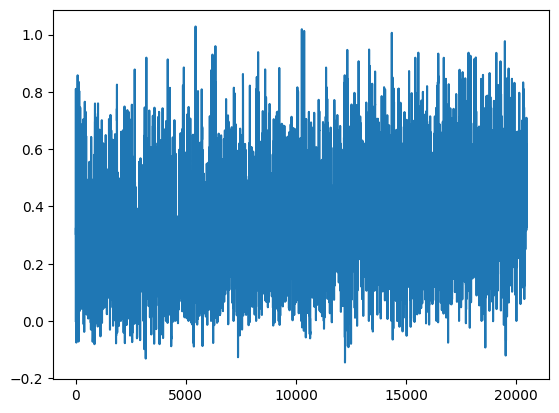

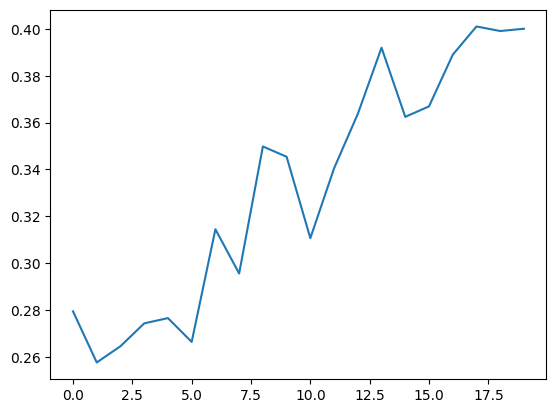

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=83.0380, Policy=0.0012, Value=166.1554
[PPO] Epoch 10: Loss=62.0842, Policy=-0.0043, Value=124.2584
[PPO] Epoch 20: Loss=46.0576, Policy=-0.0080, Value=92.2122
[PPO] Epoch 30: Loss=37.6718, Policy=-0.0147, Value=75.4538
Approx KL Learned: 0.015660617500543594
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=73.3006, Policy=0.0002, Value=146.6786
[PPO] Epoch 10: Loss=59.0928, Policy=-0.0047, Value=118.2701
[PPO] Epoch 20: Loss=49.0914, Policy=-0.0095, Value=98.2795
[PPO] Epoch 30: Loss=42.2910, Policy=-0.0139, Value=84.6853
Approx KL Learned: 0.009788330644369125
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=72.7269, Policy=0.0043, Value=145.5221
[PPO] Epoch 10: Loss=44.1451, Policy=-0.0083, Value=88.3835
[PPO] Epoch 20: Loss=32.7943, Policy=-0.0215, Value=65.7060
[PPO] Epoch 30: Loss=27.9858, Policy=-0.0263, Value=56.0998
Approx KL Learned: 0.041865430772304535
[✅] Actor-Critic 

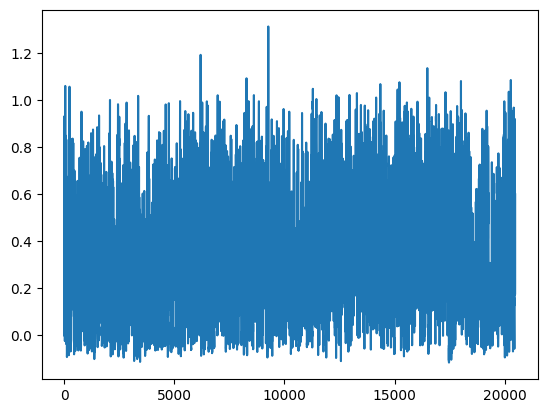

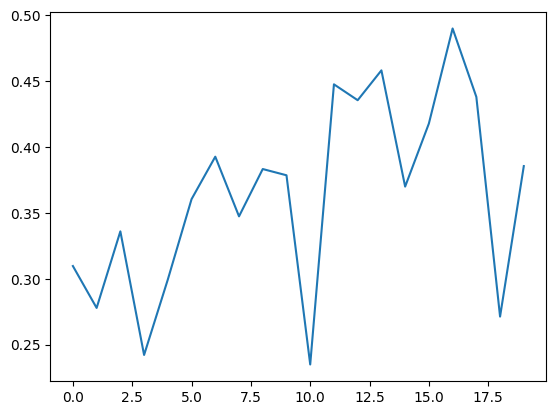

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=70.6637, Policy=0.0048, Value=141.3985
[PPO] Epoch 10: Loss=47.7492, Policy=-0.0058, Value=95.5933
[PPO] Epoch 20: Loss=37.6934, Policy=-0.0204, Value=75.5068
[PPO] Epoch 30: Loss=29.9621, Policy=-0.0236, Value=60.0517
Approx KL Learned: 0.02489195019006729
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=95.9218, Policy=0.0050, Value=191.9117
[PPO] Epoch 10: Loss=57.0000, Policy=0.0002, Value=114.0755
[PPO] Epoch 20: Loss=44.9367, Policy=-0.0059, Value=89.9636
[PPO] Epoch 30: Loss=34.9382, Policy=-0.0163, Value=69.9879
Approx KL Learned: 0.030878843739628792
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=67.6153, Policy=0.0010, Value=135.3152
[PPO] Epoch 10: Loss=49.3323, Policy=-0.0057, Value=98.7584
[PPO] Epoch 20: Loss=38.8640, Policy=-0.0138, Value=77.8371
[PPO] Epoch 30: Loss=32.8058, Policy=-0.0196, Value=65.7308
Approx KL Learned: 0.024198373779654503
[✅] Actor-Critic che

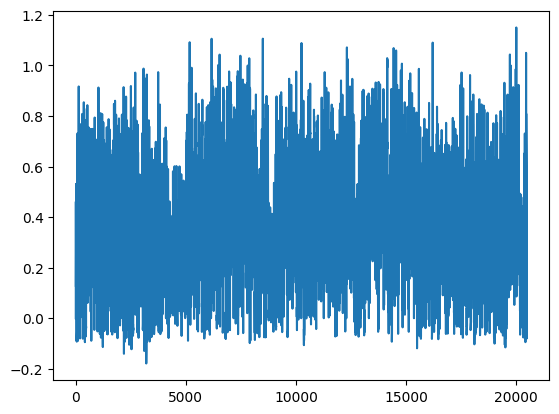

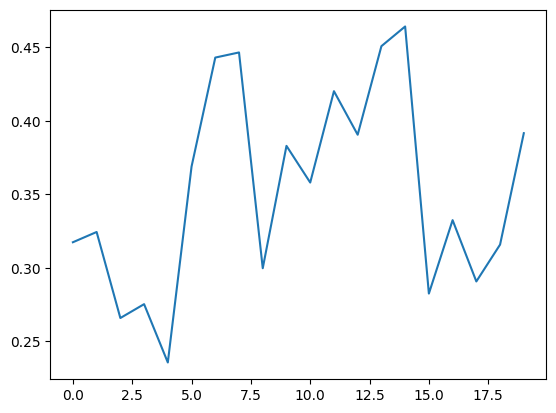

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=102.9604, Policy=0.0126, Value=205.9670
[PPO] Epoch 10: Loss=43.0845, Policy=-0.0020, Value=86.2411
[PPO] Epoch 20: Loss=30.7250, Policy=-0.0143, Value=61.5442
[PPO] Epoch 30: Loss=26.4634, Policy=-0.0023, Value=52.9946
Approx KL Learned: 0.038541026413440704
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=93.4181, Policy=0.0040, Value=186.9131
[PPO] Epoch 10: Loss=61.8885, Policy=-0.0062, Value=123.8730
[PPO] Epoch 20: Loss=44.2543, Policy=-0.0190, Value=88.6283
[PPO] Epoch 30: Loss=37.6434, Policy=-0.0195, Value=75.4129
Approx KL Learned: 0.057307563722133636
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=113.3909, Policy=0.0066, Value=226.8325
[PPO] Epoch 10: Loss=76.1998, Policy=0.0020, Value=152.4634
[PPO] Epoch 20: Loss=54.5101, Policy=-0.0085, Value=109.1044
[PPO] Epoch 30: Loss=42.4626, Policy=-0.0143, Value=85.0227
Approx KL Learned: 0.03268591687083244
[✅] Actor-Critic

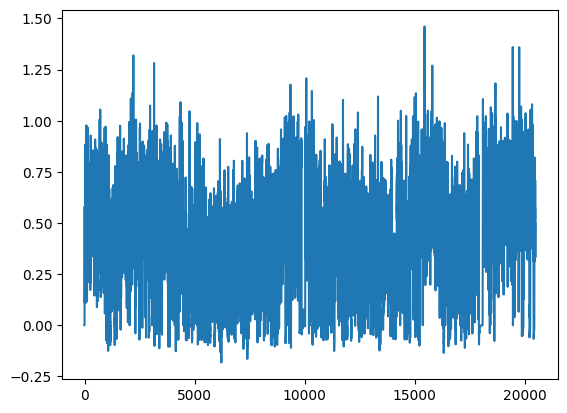

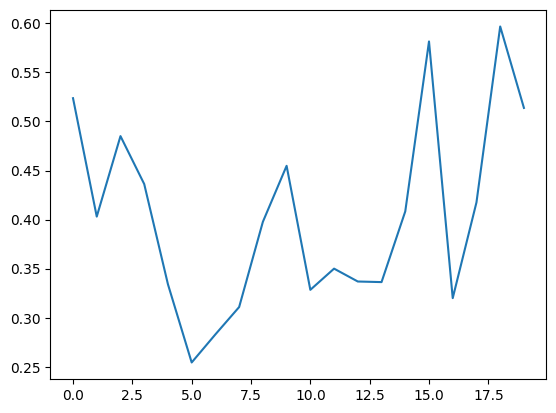

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=117.7731, Policy=0.0094, Value=235.6014
[PPO] Epoch 10: Loss=75.7404, Policy=-0.0004, Value=151.5596
[PPO] Epoch 20: Loss=57.6451, Policy=-0.0105, Value=115.3877
[PPO] Epoch 30: Loss=46.5521, Policy=-0.0160, Value=93.2142
Approx KL Learned: 0.03051767684519291
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=98.9990, Policy=0.0070, Value=198.0574
[PPO] Epoch 10: Loss=57.0714, Policy=-0.0029, Value=114.2235
[PPO] Epoch 20: Loss=37.2758, Policy=-0.0136, Value=74.6528
[PPO] Epoch 30: Loss=28.4756, Policy=-0.0207, Value=57.0665
Approx KL Learned: 0.027970092371106148
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=102.5711, Policy=0.0055, Value=205.2017
[PPO] Epoch 10: Loss=55.3689, Policy=0.0003, Value=110.8070
[PPO] Epoch 20: Loss=35.4707, Policy=-0.0124, Value=71.0341
[PPO] Epoch 30: Loss=49.5877, Policy=0.0158, Value=99.2145
Approx KL Learned: 0.027491310611367226
[✅] Actor-Critic

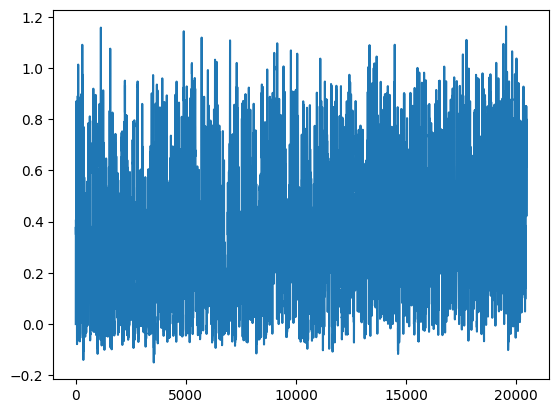

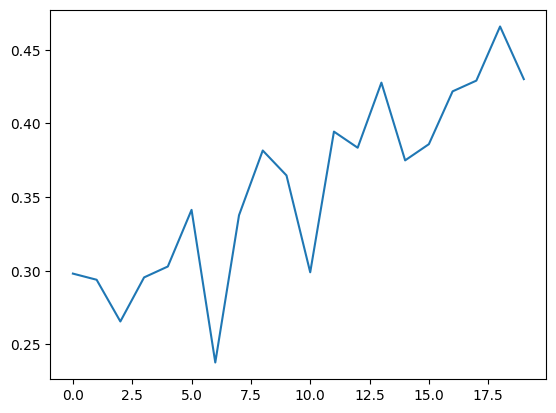

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=74.6106, Policy=0.0046, Value=149.2796
[PPO] Epoch 10: Loss=43.3596, Policy=-0.0150, Value=86.8200
[PPO] Epoch 20: Loss=33.1990, Policy=-0.0271, Value=66.5243
[PPO] Epoch 30: Loss=25.6090, Policy=-0.0370, Value=51.3628
Approx KL Learned: 0.04166453704237938
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=79.5486, Policy=0.0054, Value=159.1525
[PPO] Epoch 10: Loss=80.4252, Policy=-0.0057, Value=160.9281
[PPO] Epoch 20: Loss=48.5268, Policy=-0.0183, Value=97.1578
[PPO] Epoch 30: Loss=40.9166, Policy=-0.0231, Value=81.9471
Approx KL Learned: 0.02478756383061409
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=62.5446, Policy=0.0063, Value=125.1407
[PPO] Epoch 10: Loss=47.3417, Policy=-0.0038, Value=94.7534
[PPO] Epoch 20: Loss=44.0830, Policy=-0.0089, Value=88.2468
[PPO] Epoch 30: Loss=37.3343, Policy=-0.0138, Value=74.7585
Approx KL Learned: 0.023477938026189804
[✅] Actor-Critic che

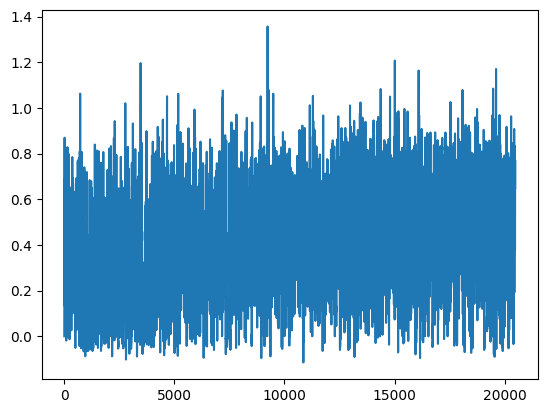

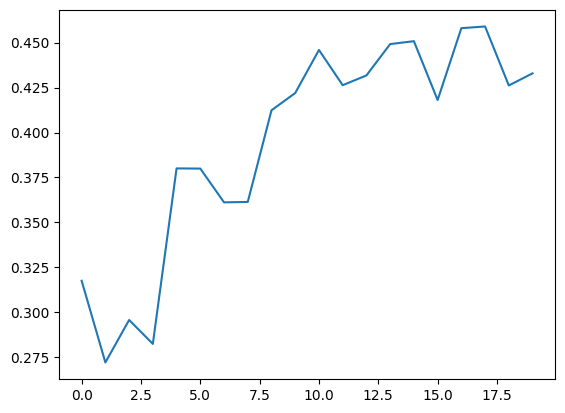

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=64.9415, Policy=0.0051, Value=129.9355
[PPO] Epoch 10: Loss=44.4311, Policy=-0.0091, Value=88.9454
[PPO] Epoch 20: Loss=30.6563, Policy=-0.0173, Value=61.4124
[PPO] Epoch 30: Loss=21.9236, Policy=-0.0246, Value=43.9629
Approx KL Learned: 0.057791635394096375
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=63.7845, Policy=0.0038, Value=127.6201
[PPO] Epoch 10: Loss=38.4850, Policy=-0.0016, Value=77.0372
[PPO] Epoch 20: Loss=24.4171, Policy=-0.0149, Value=48.9251
[PPO] Epoch 30: Loss=17.7683, Policy=-0.0207, Value=35.6415
Approx KL Learned: 0.029976632446050644
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=79.5658, Policy=0.0039, Value=159.1738
[PPO] Epoch 10: Loss=47.5774, Policy=-0.0067, Value=95.2195
[PPO] Epoch 20: Loss=31.8327, Policy=-0.0182, Value=63.7518
[PPO] Epoch 30: Loss=22.5315, Policy=-0.0242, Value=45.1621
Approx KL Learned: 0.04280172288417816
[✅] Actor-Critic che

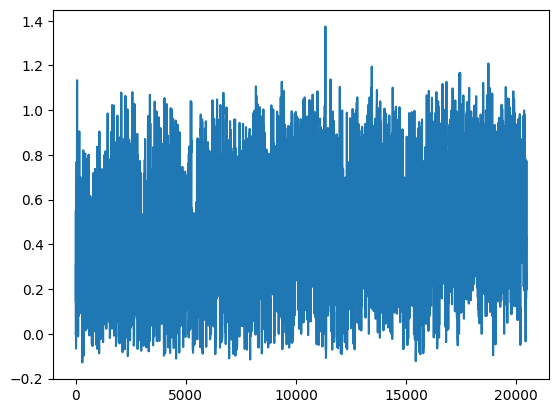

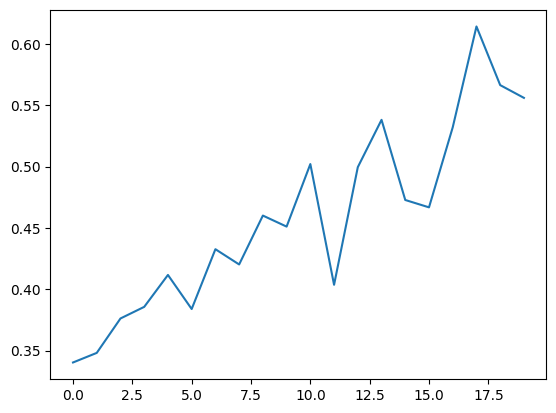

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=112.3129, Policy=0.0051, Value=224.6908
[PPO] Epoch 10: Loss=48.7745, Policy=-0.0113, Value=97.6476
[PPO] Epoch 20: Loss=35.5813, Policy=-0.0220, Value=71.2797
[PPO] Epoch 30: Loss=28.8823, Policy=-0.0285, Value=57.8980
Approx KL Learned: 0.03058360144495964
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=70.9261, Policy=0.0050, Value=141.9176
[PPO] Epoch 10: Loss=45.5447, Policy=-0.0034, Value=91.1718
[PPO] Epoch 20: Loss=34.6907, Policy=-0.0110, Value=69.4799
[PPO] Epoch 30: Loss=27.1965, Policy=-0.0178, Value=54.5048
Approx KL Learned: 0.02490784041583538
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=65.1741, Policy=0.0046, Value=130.4135
[PPO] Epoch 10: Loss=39.7285, Policy=-0.0073, Value=79.5455
[PPO] Epoch 20: Loss=25.2357, Policy=-0.0241, Value=50.5914
[PPO] Epoch 30: Loss=20.0908, Policy=-0.0313, Value=40.3176
Approx KL Learned: 0.030578620731830597
[✅] Actor-Critic che

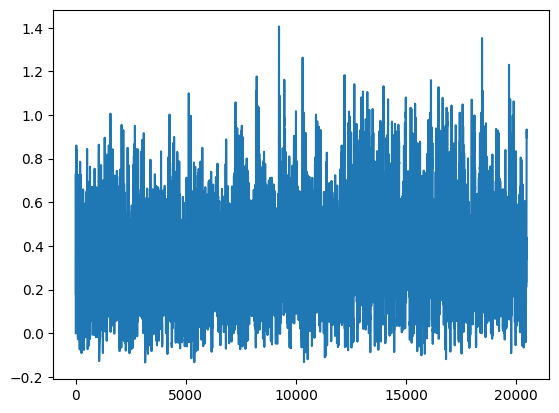

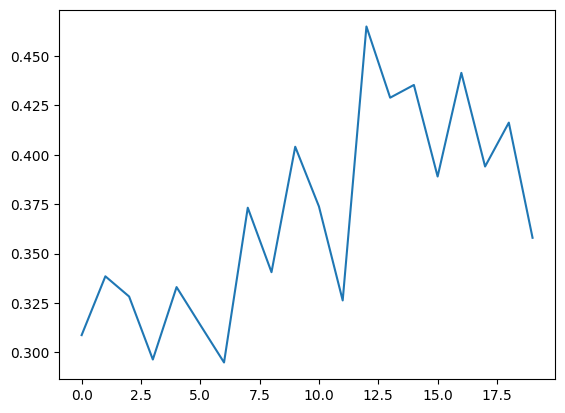

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=127.7572, Policy=0.0098, Value=255.5616
[PPO] Epoch 10: Loss=64.8749, Policy=0.0001, Value=129.8199
[PPO] Epoch 20: Loss=44.4074, Policy=-0.0319, Value=88.9521
[PPO] Epoch 30: Loss=27.3973, Policy=-0.0424, Value=54.9497
Approx KL Learned: 0.05497211962938309
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=102.1768, Policy=0.0085, Value=204.4110
[PPO] Epoch 10: Loss=55.9526, Policy=-0.0070, Value=111.9929
[PPO] Epoch 20: Loss=38.1447, Policy=-0.0194, Value=76.4024
[PPO] Epoch 30: Loss=25.7373, Policy=-0.0283, Value=51.6057
Approx KL Learned: 0.03423070162534714
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=77.6151, Policy=0.0058, Value=155.2846
[PPO] Epoch 10: Loss=46.8878, Policy=-0.0076, Value=93.8569
[PPO] Epoch 20: Loss=29.1355, Policy=-0.0219, Value=58.3802
[PPO] Epoch 30: Loss=19.9144, Policy=-0.0314, Value=39.9577
Approx KL Learned: 0.03217153251171112
[✅] Actor-Critic ch

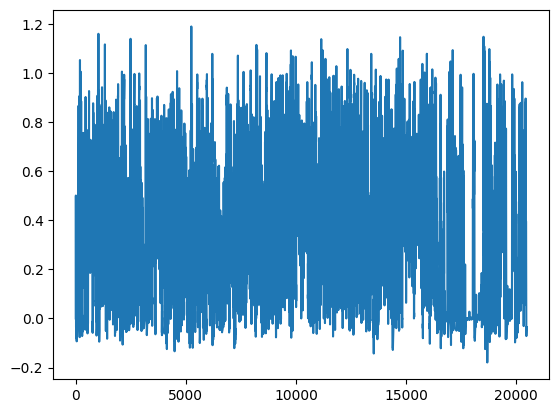

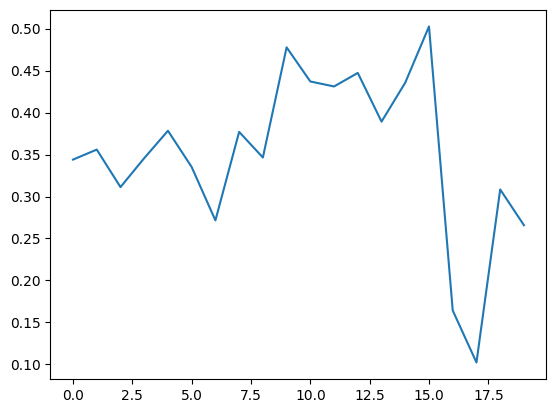

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=136.1127, Policy=0.0051, Value=272.2755
[PPO] Epoch 10: Loss=59.6160, Policy=-0.0025, Value=119.3006
[PPO] Epoch 20: Loss=32.1007, Policy=-0.0172, Value=64.3019
[PPO] Epoch 30: Loss=21.3843, Policy=-0.0313, Value=42.8986
Approx KL Learned: 0.06902681291103363
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=138.0915, Policy=0.0079, Value=276.2242
[PPO] Epoch 10: Loss=82.3089, Policy=0.0023, Value=164.6703
[PPO] Epoch 20: Loss=57.4565, Policy=-0.0068, Value=114.9859
[PPO] Epoch 30: Loss=45.0967, Policy=-0.0150, Value=90.2828
Approx KL Learned: 0.027437757700681686
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=123.9610, Policy=0.0099, Value=247.9698
[PPO] Epoch 10: Loss=85.5969, Policy=-0.0014, Value=171.2664
[PPO] Epoch 20: Loss=63.5900, Policy=-0.0085, Value=127.2661
[PPO] Epoch 30: Loss=48.9202, Policy=-0.0105, Value=97.9349
Approx KL Learned: 0.03922650218009949
[✅] Actor-Crit

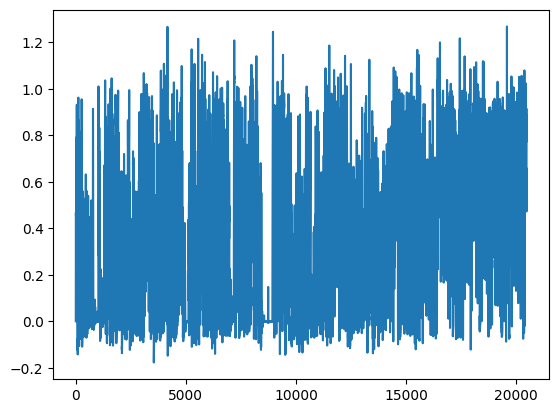

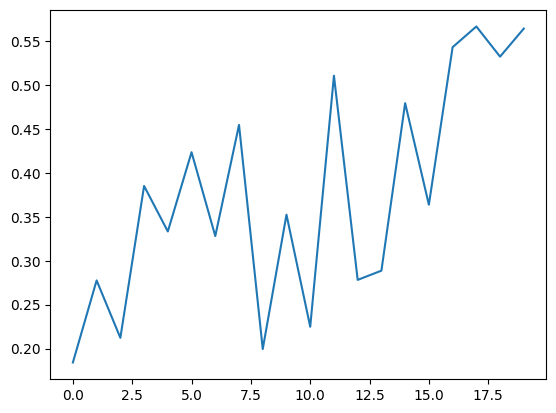

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=80.6995, Policy=0.0082, Value=161.4734
[PPO] Epoch 10: Loss=51.0961, Policy=-0.0057, Value=102.2955
[PPO] Epoch 20: Loss=35.9004, Policy=-0.0170, Value=71.9275
[PPO] Epoch 30: Loss=25.9078, Policy=-0.0183, Value=51.9470
Approx KL Learned: 0.09199468791484833
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=73.8875, Policy=0.0051, Value=147.8624
[PPO] Epoch 10: Loss=43.6643, Policy=-0.0058, Value=87.4372
[PPO] Epoch 20: Loss=26.7898, Policy=-0.0162, Value=53.7097
[PPO] Epoch 30: Loss=17.1638, Policy=0.0474, Value=34.3111
Approx KL Learned: 0.07147634774446487
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=105.4269, Policy=0.0008, Value=210.9537
[PPO] Epoch 10: Loss=63.9318, Policy=-0.0033, Value=127.9691
[PPO] Epoch 20: Loss=44.9891, Policy=-0.0134, Value=90.1070
[PPO] Epoch 30: Loss=31.2521, Policy=-0.0181, Value=62.6417
Approx KL Learned: 0.014391563832759857
[✅] Actor-Critic ch

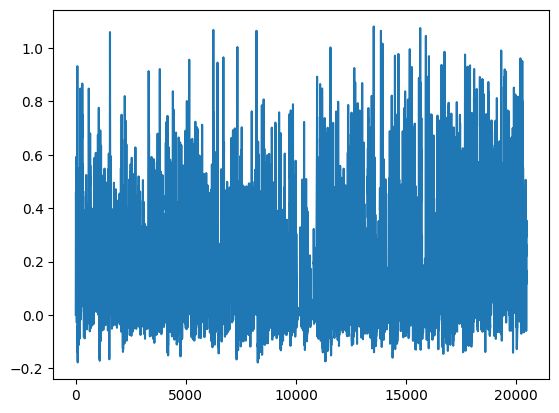

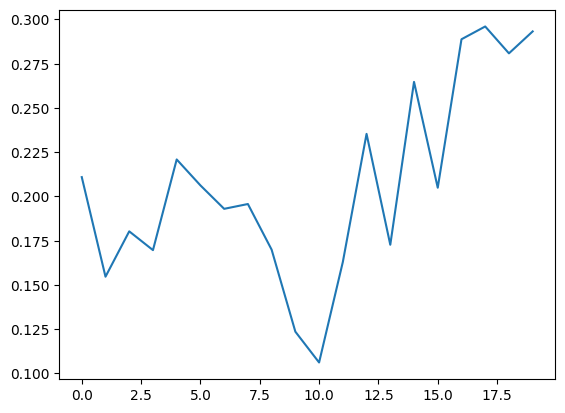

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=128.0620, Policy=0.0009, Value=256.2103
[PPO] Epoch 10: Loss=66.8943, Policy=-0.0052, Value=133.8858
[PPO] Epoch 20: Loss=40.8933, Policy=-0.0175, Value=81.9082
[PPO] Epoch 30: Loss=27.3986, Policy=-0.0282, Value=54.9376
Approx KL Learned: 0.02677469328045845
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=80.5870, Policy=0.0063, Value=161.2453
[PPO] Epoch 10: Loss=58.0480, Policy=0.0032, Value=116.1753
[PPO] Epoch 20: Loss=36.2643, Policy=-0.0132, Value=72.6369
[PPO] Epoch 30: Loss=25.7021, Policy=-0.0239, Value=51.5339
Approx KL Learned: 0.02184392511844635
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=98.6765, Policy=0.0046, Value=197.4258
[PPO] Epoch 10: Loss=50.0139, Policy=-0.0080, Value=100.1233
[PPO] Epoch 20: Loss=30.0850, Policy=-0.0205, Value=60.2901
[PPO] Epoch 30: Loss=22.4228, Policy=-0.0285, Value=44.9810
Approx KL Learned: 0.023568008095026016
[✅] Actor-Critic c

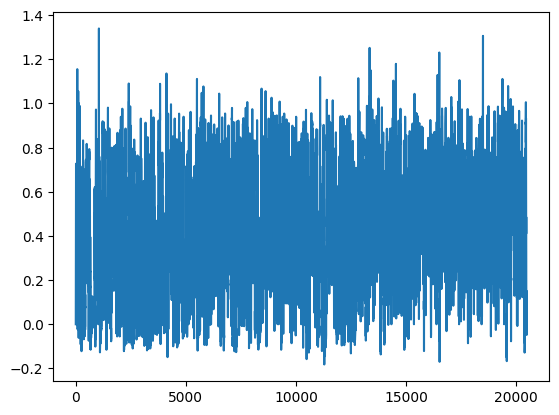

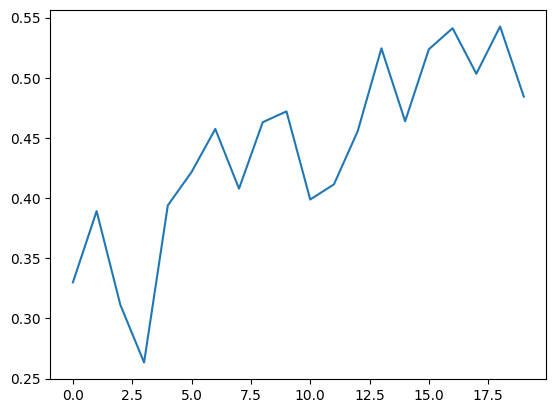

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=113.0956, Policy=0.0064, Value=226.2626
[PPO] Epoch 10: Loss=55.8033, Policy=-0.0055, Value=111.7023
[PPO] Epoch 20: Loss=33.4452, Policy=-0.0243, Value=67.0226
[PPO] Epoch 30: Loss=18.4298, Policy=-0.0399, Value=37.0231
Approx KL Learned: 0.04558863490819931
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=125.8656, Policy=0.0059, Value=251.8072
[PPO] Epoch 10: Loss=49.7946, Policy=-0.0043, Value=99.6857
[PPO] Epoch 20: Loss=26.0457, Policy=-0.0248, Value=52.2288
[PPO] Epoch 30: Loss=14.3792, Policy=-0.0412, Value=28.9267
Approx KL Learned: 0.03564643859863281
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=112.9104, Policy=0.0048, Value=225.8921
[PPO] Epoch 10: Loss=56.4900, Policy=-0.0001, Value=113.0638
[PPO] Epoch 20: Loss=30.3821, Policy=-0.0191, Value=60.8838
[PPO] Epoch 30: Loss=20.5330, Policy=-0.0322, Value=41.2116
Approx KL Learned: 0.04451027140021324
[✅] Actor-Critic 

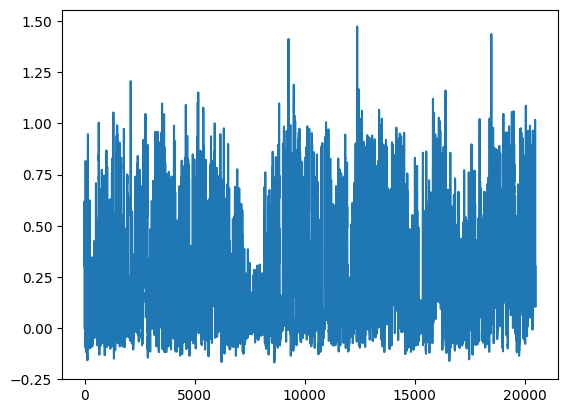

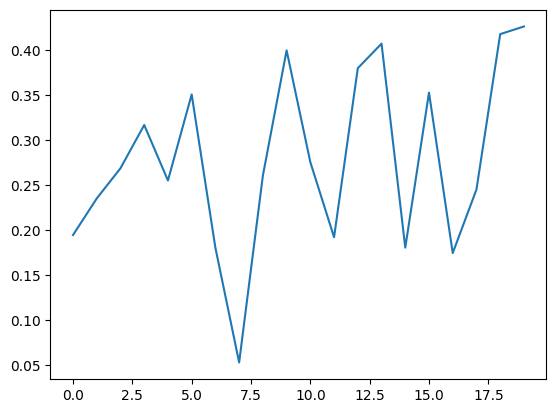

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=97.8423, Policy=0.0058, Value=195.7710
[PPO] Epoch 10: Loss=53.6211, Policy=0.0003, Value=107.3405
[PPO] Epoch 20: Loss=27.9923, Policy=-0.0150, Value=56.1123
[PPO] Epoch 30: Loss=15.1874, Policy=-0.0232, Value=30.5178
Approx KL Learned: 0.29070109128952026
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=68.6429, Policy=0.0035, Value=137.3607
[PPO] Epoch 10: Loss=39.5966, Policy=-0.0092, Value=79.2942
[PPO] Epoch 20: Loss=24.2002, Policy=-0.0156, Value=48.5144
[PPO] Epoch 30: Loss=16.4039, Policy=-0.0235, Value=32.9362
Approx KL Learned: 0.0262717567384243
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=71.2865, Policy=0.0028, Value=142.6494
[PPO] Epoch 10: Loss=36.9809, Policy=-0.0104, Value=74.0642
[PPO] Epoch 20: Loss=23.9430, Policy=-0.0233, Value=48.0134
[PPO] Epoch 30: Loss=15.9706, Policy=-0.0303, Value=32.0824
Approx KL Learned: 0.023241708055138588
[✅] Actor-Critic check

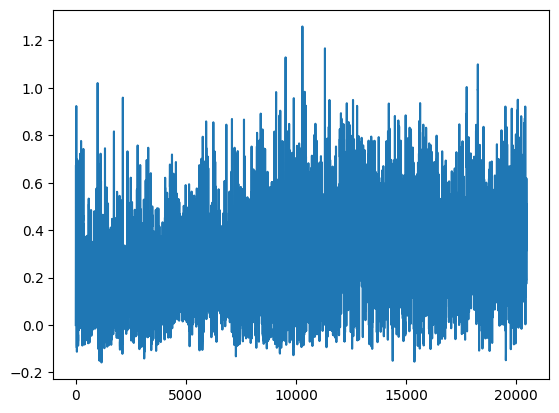

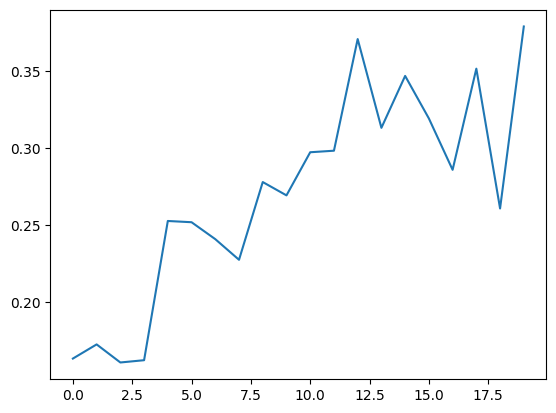

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=57.6488, Policy=0.0135, Value=115.3440
[PPO] Epoch 10: Loss=41.8509, Policy=-0.0015, Value=83.7800
[PPO] Epoch 20: Loss=34.6980, Policy=0.0048, Value=69.4584
[PPO] Epoch 30: Loss=24.7055, Policy=-0.0064, Value=49.5075
Approx KL Learned: 0.048903681337833405
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=45.7773, Policy=0.0048, Value=91.6225
[PPO] Epoch 10: Loss=29.8234, Policy=-0.0101, Value=59.7432
[PPO] Epoch 20: Loss=22.6380, Policy=0.0076, Value=45.3288
[PPO] Epoch 30: Loss=19.0438, Policy=-0.0063, Value=38.1833
Approx KL Learned: 0.04546467959880829
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=56.5810, Policy=0.0075, Value=113.2224
[PPO] Epoch 10: Loss=35.0185, Policy=-0.0123, Value=70.1354
[PPO] Epoch 20: Loss=17.8614, Policy=-0.0142, Value=35.8301
[PPO] Epoch 30: Loss=12.7628, Policy=-0.0373, Value=25.6762
Approx KL Learned: 0.03926323726773262
[✅] Actor-Critic checkpo

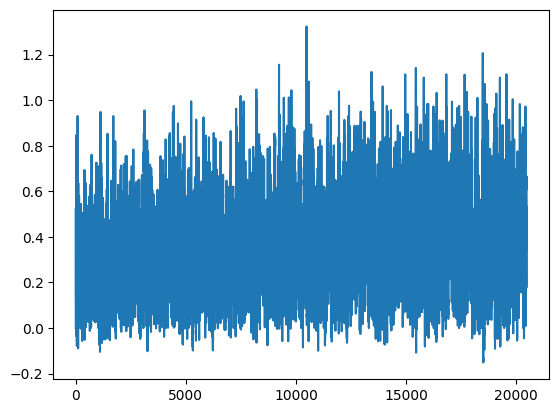

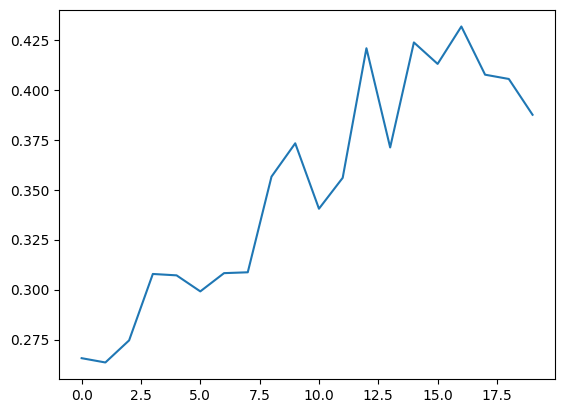

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=99.5088, Policy=0.0087, Value=199.0712
[PPO] Epoch 10: Loss=57.3089, Policy=-0.0148, Value=114.7216
[PPO] Epoch 20: Loss=32.0873, Policy=-0.0398, Value=64.3300
[PPO] Epoch 30: Loss=20.1603, Policy=-0.0524, Value=40.5014
Approx KL Learned: 0.0792856216430664
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=114.2358, Policy=0.0086, Value=228.5364
[PPO] Epoch 10: Loss=48.2329, Policy=-0.0024, Value=96.5522
[PPO] Epoch 20: Loss=27.1207, Policy=-0.0121, Value=54.3498
[PPO] Epoch 30: Loss=18.5242, Policy=-0.0233, Value=37.1777
Approx KL Learned: 0.03622451052069664
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=107.6670, Policy=0.0074, Value=215.3943
[PPO] Epoch 10: Loss=56.2060, Policy=0.0005, Value=112.4841
[PPO] Epoch 20: Loss=30.5742, Policy=-0.0159, Value=61.2529
[PPO] Epoch 30: Loss=20.8976, Policy=-0.0276, Value=41.9240
Approx KL Learned: 0.026015248149633408
[✅] Actor-Critic ch

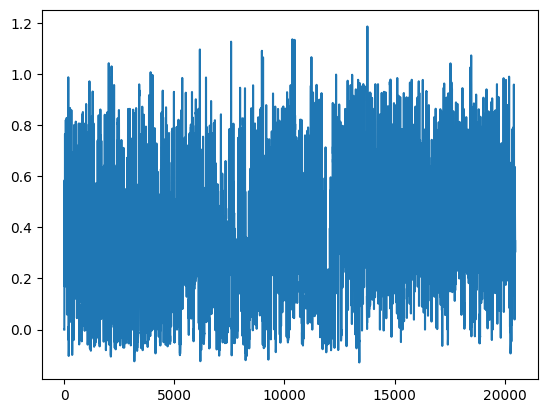

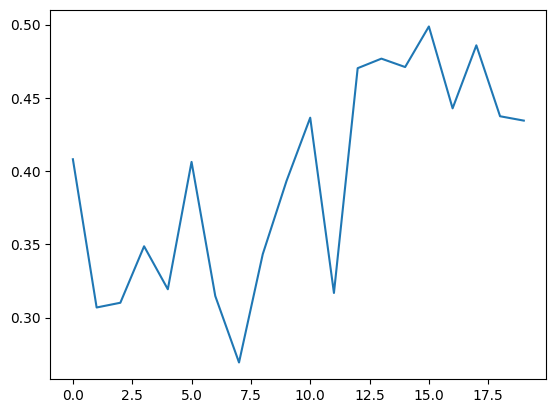

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=68.8680, Policy=0.0015, Value=137.8224
[PPO] Epoch 10: Loss=41.7398, Policy=-0.0095, Value=83.5879
[PPO] Epoch 20: Loss=29.0272, Policy=-0.0072, Value=58.1565
[PPO] Epoch 30: Loss=21.6422, Policy=-0.0166, Value=43.4069
Approx KL Learned: 0.008278675377368927
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=59.3125, Policy=0.0011, Value=118.7132
[PPO] Epoch 10: Loss=50.3969, Policy=-0.0141, Value=100.9116
[PPO] Epoch 20: Loss=39.5429, Policy=-0.0193, Value=79.2141
[PPO] Epoch 30: Loss=38.1933, Policy=-0.0232, Value=76.5231
Approx KL Learned: 0.018276147544384003
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=54.1798, Policy=0.0036, Value=108.4413
[PPO] Epoch 10: Loss=45.7494, Policy=-0.0178, Value=91.6208
[PPO] Epoch 20: Loss=34.9449, Policy=-0.0232, Value=70.0181
[PPO] Epoch 30: Loss=27.1316, Policy=-0.0282, Value=54.4022
Approx KL Learned: 0.022902993485331535
[✅] Actor-Critic c

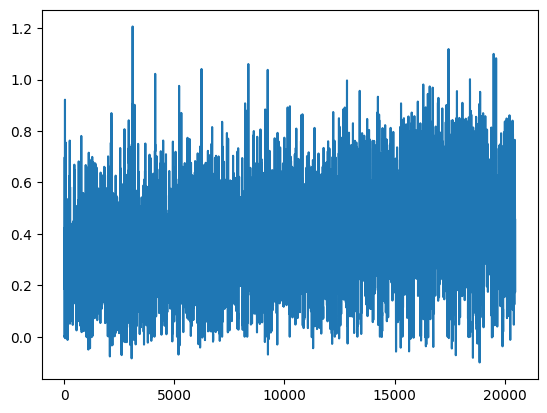

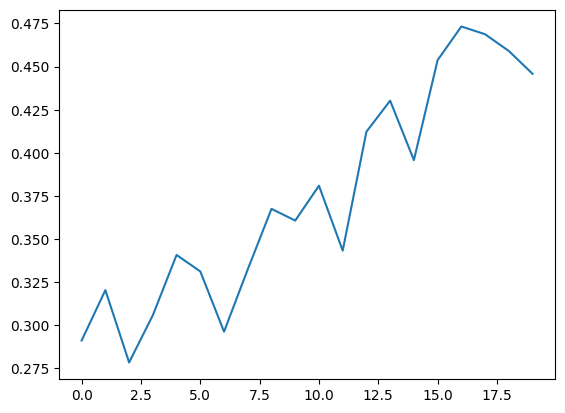

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=122.5121, Policy=0.0034, Value=245.1011
[PPO] Epoch 10: Loss=63.5701, Policy=-0.0055, Value=127.2350
[PPO] Epoch 20: Loss=36.2876, Policy=-0.0144, Value=72.6870
[PPO] Epoch 30: Loss=24.2160, Policy=-0.0233, Value=48.5620
Approx KL Learned: 0.02242986485362053
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=66.4921, Policy=0.0035, Value=133.0580
[PPO] Epoch 10: Loss=39.0734, Policy=-0.0092, Value=78.2466
[PPO] Epoch 20: Loss=23.1580, Policy=-0.0208, Value=46.4376
[PPO] Epoch 30: Loss=15.9954, Policy=-0.0268, Value=32.1234
Approx KL Learned: 0.02344181016087532
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=82.8217, Policy=0.0016, Value=165.7199
[PPO] Epoch 10: Loss=35.2817, Policy=-0.0142, Value=70.6687
[PPO] Epoch 20: Loss=19.6624, Policy=-0.0249, Value=39.4514
[PPO] Epoch 30: Loss=11.1847, Policy=-0.0365, Value=22.5175
Approx KL Learned: 0.022198498249053955
[✅] Actor-Critic ch

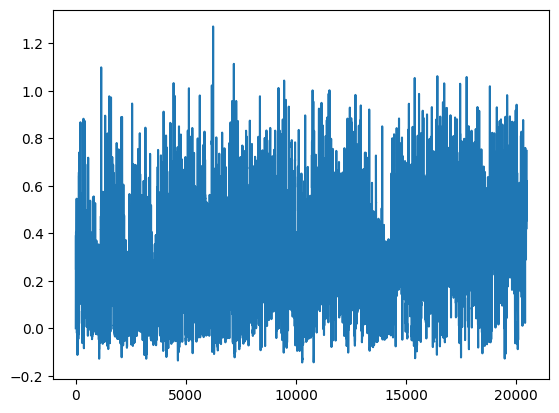

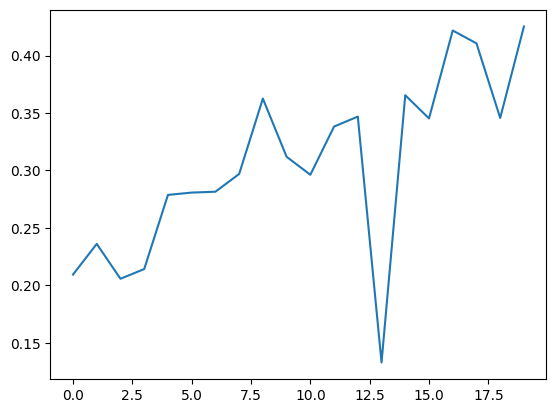

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=114.6716, Policy=0.0066, Value=229.4057
[PPO] Epoch 10: Loss=59.9503, Policy=-0.0069, Value=119.9923
[PPO] Epoch 20: Loss=29.9162, Policy=-0.0241, Value=59.9571
[PPO] Epoch 30: Loss=16.9389, Policy=-0.0385, Value=34.0326
Approx KL Learned: 0.04439853876829147
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=82.8201, Policy=0.0050, Value=165.7174
[PPO] Epoch 10: Loss=49.4487, Policy=-0.0017, Value=98.9873
[PPO] Epoch 20: Loss=35.0102, Policy=-0.0170, Value=70.1416
[PPO] Epoch 30: Loss=24.1201, Policy=-0.0239, Value=48.3760
Approx KL Learned: 0.025744538754224777
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=162.5204, Policy=0.0031, Value=325.1166
[PPO] Epoch 10: Loss=65.4572, Policy=0.0017, Value=130.9964
[PPO] Epoch 20: Loss=33.9217, Policy=-0.0116, Value=67.9517
[PPO] Epoch 30: Loss=19.0886, Policy=-0.0213, Value=38.3051
Approx KL Learned: 0.015601227059960365
[✅] Actor-Critic 

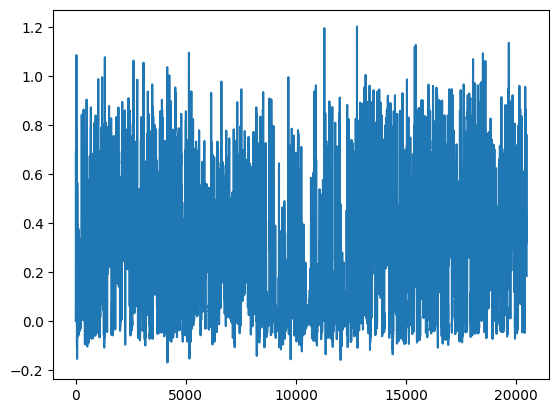

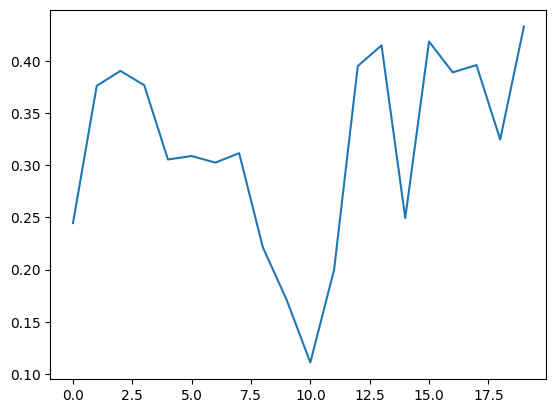

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=77.7556, Policy=0.0083, Value=155.5748
[PPO] Epoch 10: Loss=43.9936, Policy=-0.0028, Value=88.0751
[PPO] Epoch 20: Loss=25.5828, Policy=-0.0192, Value=51.2848
[PPO] Epoch 30: Loss=16.6522, Policy=-0.0317, Value=33.4487
Approx KL Learned: 0.0323067232966423
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=74.5145, Policy=0.0062, Value=149.0950
[PPO] Epoch 10: Loss=27.9052, Policy=-0.0147, Value=55.9197
[PPO] Epoch 20: Loss=17.9300, Policy=-0.0086, Value=35.9635
[PPO] Epoch 30: Loss=11.9013, Policy=0.0029, Value=23.8813
Approx KL Learned: 0.07397906482219696
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=63.1497, Policy=0.0072, Value=126.3590
[PPO] Epoch 10: Loss=31.3026, Policy=-0.0087, Value=62.6976
[PPO] Epoch 20: Loss=17.3726, Policy=-0.0241, Value=34.8699
[PPO] Epoch 30: Loss=11.8321, Policy=-0.0416, Value=23.8241
Approx KL Learned: 0.04602694511413574
[✅] Actor-Critic checkpo

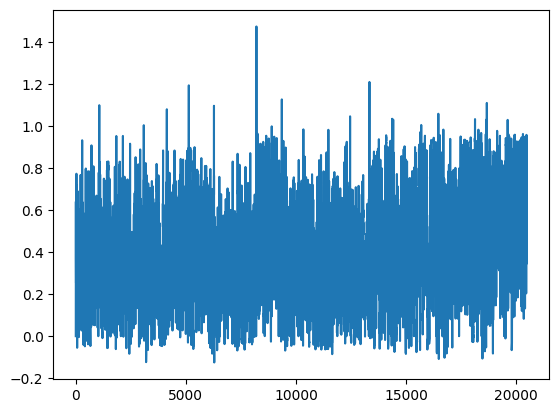

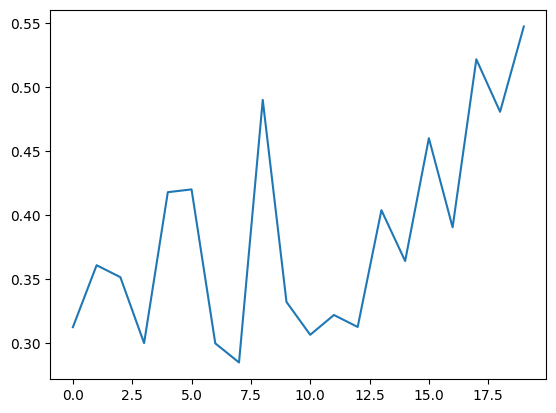

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=101.5331, Policy=0.0033, Value=203.1420
[PPO] Epoch 10: Loss=42.3455, Policy=-0.0101, Value=84.7943
[PPO] Epoch 20: Loss=24.1988, Policy=-0.0230, Value=48.5279
[PPO] Epoch 30: Loss=16.7186, Policy=-0.0350, Value=33.5912
Approx KL Learned: 0.0354851670563221
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=114.9559, Policy=0.0053, Value=229.9854
[PPO] Epoch 10: Loss=46.0549, Policy=-0.0146, Value=92.2220
[PPO] Epoch 20: Loss=23.1861, Policy=-0.0359, Value=46.5267
[PPO] Epoch 30: Loss=15.7610, Policy=-0.0465, Value=31.6968
Approx KL Learned: 0.0363173708319664
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=87.2004, Policy=0.0102, Value=174.4579
[PPO] Epoch 10: Loss=49.6251, Policy=-0.0066, Value=99.3406
[PPO] Epoch 20: Loss=30.2082, Policy=-0.0217, Value=60.5349
[PPO] Epoch 30: Loss=18.9906, Policy=-0.0335, Value=38.1202
Approx KL Learned: 0.035622186958789825
[✅] Actor-Critic chec

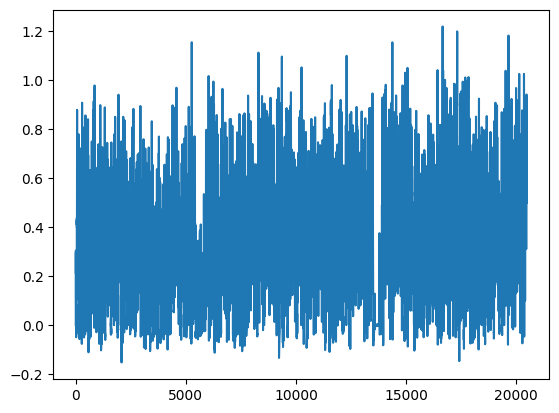

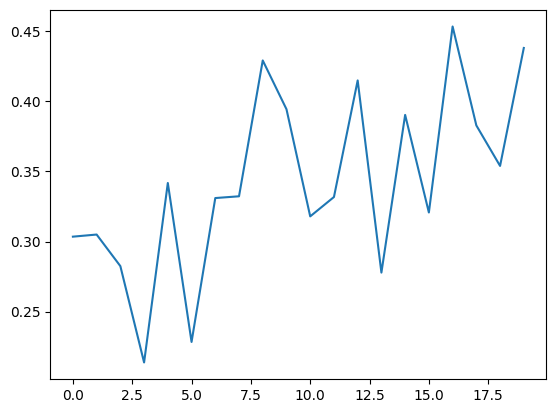

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=115.2221, Policy=0.0085, Value=230.5083
[PPO] Epoch 10: Loss=49.4710, Policy=-0.0035, Value=99.0309
[PPO] Epoch 20: Loss=31.8462, Policy=-0.0242, Value=63.8239
[PPO] Epoch 30: Loss=19.8707, Policy=-0.0430, Value=39.9068
Approx KL Learned: 0.04133829474449158
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=62.9210, Policy=0.0119, Value=125.8927
[PPO] Epoch 10: Loss=43.9982, Policy=-0.0056, Value=88.0833
[PPO] Epoch 20: Loss=30.3375, Policy=-0.0216, Value=60.7925
[PPO] Epoch 30: Loss=21.3689, Policy=-0.0309, Value=42.8734
Approx KL Learned: 0.04246867820620537
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=60.9862, Policy=0.0070, Value=122.0287
[PPO] Epoch 10: Loss=45.6617, Policy=-0.0008, Value=91.3951
[PPO] Epoch 20: Loss=34.5687, Policy=-0.0219, Value=69.2482
[PPO] Epoch 30: Loss=25.3417, Policy=-0.0308, Value=50.8106
Approx KL Learned: 0.07052499800920486
[✅] Actor-Critic chec

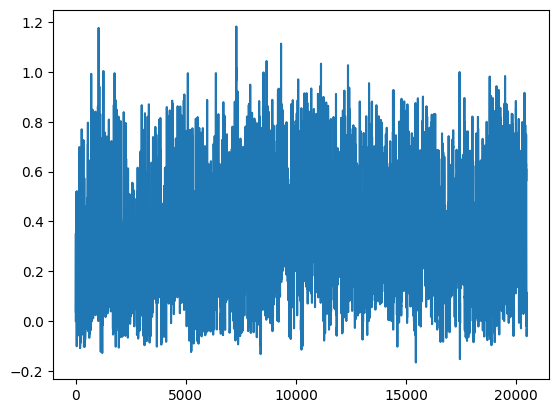

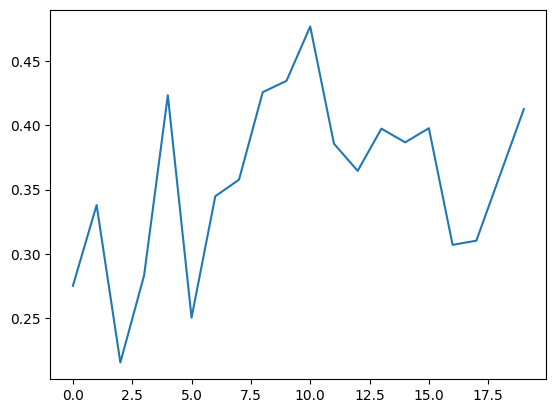

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=94.5515, Policy=0.0041, Value=189.1821
[PPO] Epoch 10: Loss=41.7173, Policy=-0.0106, Value=83.5412
[PPO] Epoch 20: Loss=25.7201, Policy=-0.0299, Value=51.5860
[PPO] Epoch 30: Loss=16.7530, Policy=-0.0420, Value=33.6754
Approx KL Learned: 0.025509284809231758
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=59.0212, Policy=0.0056, Value=118.1128
[PPO] Epoch 10: Loss=32.3009, Policy=-0.0102, Value=64.7039
[PPO] Epoch 20: Loss=18.5018, Policy=-0.0283, Value=37.1397
[PPO] Epoch 30: Loss=12.8910, Policy=-0.0409, Value=25.9443
Approx KL Learned: 0.041565507650375366
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=112.1651, Policy=0.0055, Value=224.4128
[PPO] Epoch 10: Loss=49.2745, Policy=-0.0033, Value=98.6468
[PPO] Epoch 20: Loss=31.1931, Policy=-0.0290, Value=62.5353
[PPO] Epoch 30: Loss=23.9045, Policy=-0.0487, Value=47.9967
Approx KL Learned: 0.02748480811715126
[✅] Actor-Critic ch

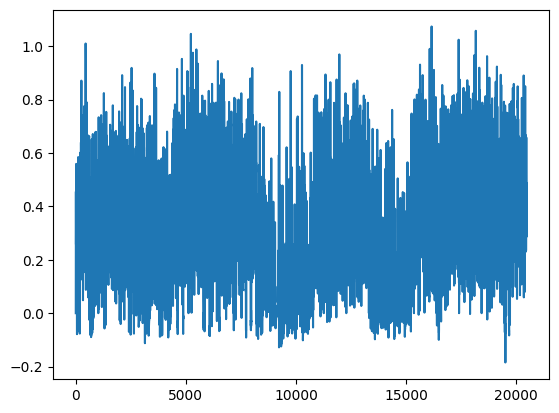

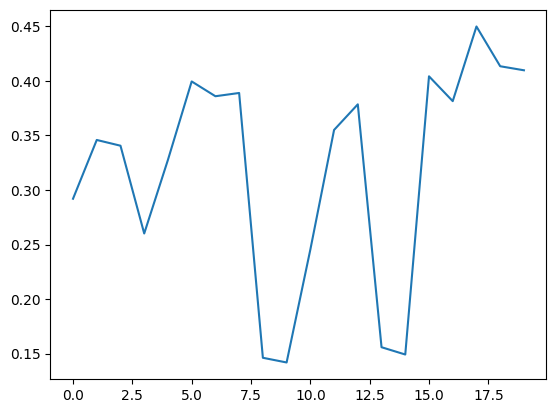

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=126.6845, Policy=0.0080, Value=253.4493
[PPO] Epoch 10: Loss=75.5947, Policy=-0.0008, Value=151.2863
[PPO] Epoch 20: Loss=53.2942, Policy=-0.0096, Value=106.7038
[PPO] Epoch 30: Loss=40.1075, Policy=-0.0160, Value=80.3419
Approx KL Learned: 0.02365058660507202
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=120.6552, Policy=0.0045, Value=241.3947
[PPO] Epoch 10: Loss=49.2654, Policy=-0.0095, Value=98.6434
[PPO] Epoch 20: Loss=23.1945, Policy=-0.0301, Value=46.5428
[PPO] Epoch 30: Loss=16.5127, Policy=-0.0486, Value=33.2142
Approx KL Learned: 0.03523179516196251
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=85.5064, Policy=0.0097, Value=171.0801
[PPO] Epoch 10: Loss=44.7066, Policy=-0.0150, Value=89.5262
[PPO] Epoch 20: Loss=27.6251, Policy=-0.0334, Value=55.4003
[PPO] Epoch 30: Loss=16.6460, Policy=-0.0394, Value=33.4565
Approx KL Learned: 0.042838044464588165
[✅] Actor-Critic 

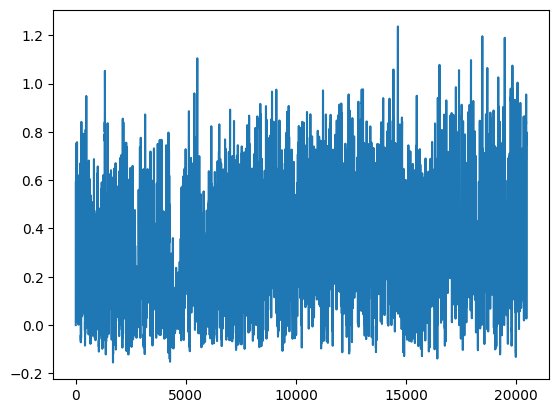

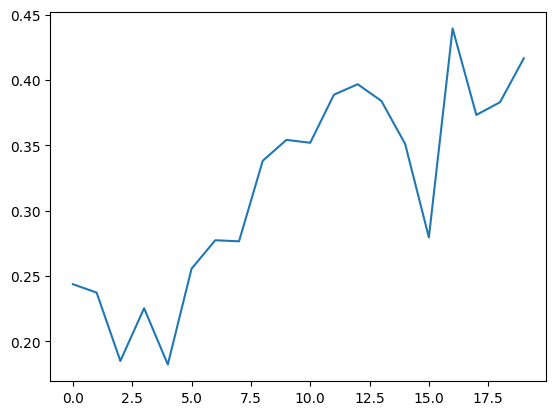

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=90.8239, Policy=0.0138, Value=181.7054
[PPO] Epoch 10: Loss=41.3827, Policy=-0.0066, Value=82.8642
[PPO] Epoch 20: Loss=26.0637, Policy=-0.0259, Value=52.2645
[PPO] Epoch 30: Loss=16.7465, Policy=-0.0424, Value=33.6632
Approx KL Learned: 0.05463162809610367
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=49.8407, Policy=0.0100, Value=99.7452
[PPO] Epoch 10: Loss=33.4490, Policy=-0.0065, Value=66.9915
[PPO] Epoch 20: Loss=24.3396, Policy=-0.0241, Value=48.8099
[PPO] Epoch 30: Loss=16.8038, Policy=0.0612, Value=33.5629
Approx KL Learned: 0.17136575281620026
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=72.0045, Policy=0.0106, Value=144.0634
[PPO] Epoch 10: Loss=42.6716, Policy=0.0115, Value=85.3967
[PPO] Epoch 20: Loss=21.1877, Policy=-0.0164, Value=42.4825
[PPO] Epoch 30: Loss=11.9267, Policy=-0.0338, Value=23.9930
Approx KL Learned: 0.056159473955631256
[✅] Actor-Critic checkpo

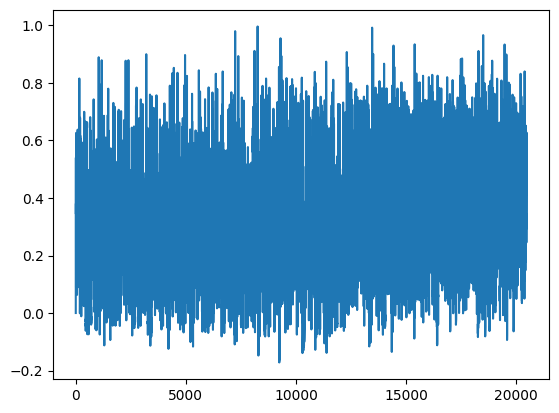

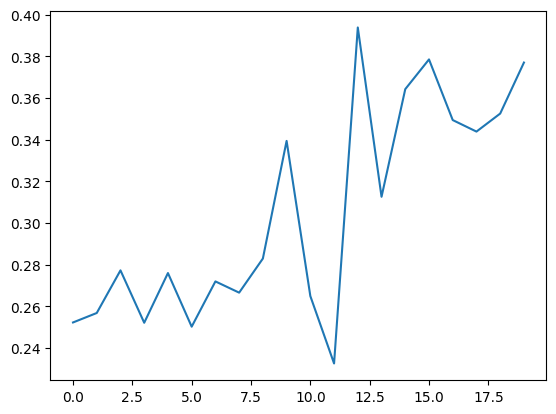

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=100.5276, Policy=0.0121, Value=201.1096
[PPO] Epoch 10: Loss=64.0359, Policy=0.0089, Value=128.1299
[PPO] Epoch 20: Loss=42.2358, Policy=-0.0114, Value=84.5714
[PPO] Epoch 30: Loss=31.8874, Policy=-0.0193, Value=63.8906
Approx KL Learned: 0.03562013804912567
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=62.0194, Policy=0.0072, Value=124.0955
[PPO] Epoch 10: Loss=49.2172, Policy=-0.0017, Value=98.5085
[PPO] Epoch 20: Loss=35.0970, Policy=-0.0142, Value=70.2953
[PPO] Epoch 30: Loss=31.4278, Policy=-0.0238, Value=62.9704
Approx KL Learned: 0.03942909836769104
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=55.3109, Policy=0.0088, Value=110.6772
[PPO] Epoch 10: Loss=38.7404, Policy=-0.0020, Value=77.5589
[PPO] Epoch 20: Loss=28.5009, Policy=-0.0162, Value=57.1079
[PPO] Epoch 30: Loss=22.6974, Policy=-0.0272, Value=45.5217
Approx KL Learned: 0.03527604043483734
[✅] Actor-Critic chec

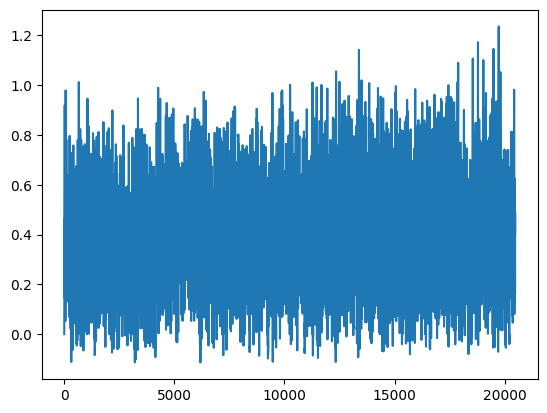

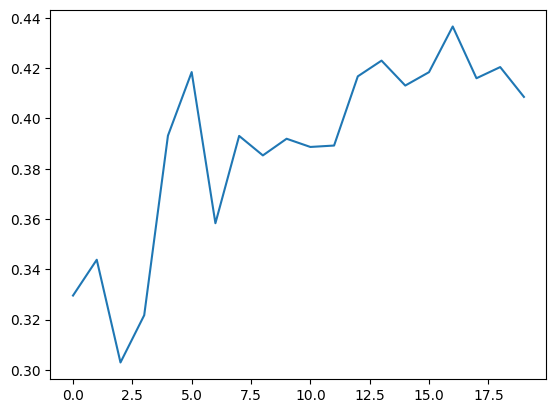

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=97.5684, Policy=0.0114, Value=195.1923
[PPO] Epoch 10: Loss=54.2372, Policy=-0.0111, Value=108.5745
[PPO] Epoch 20: Loss=29.2734, Policy=-0.0325, Value=58.6903
[PPO] Epoch 30: Loss=17.7480, Policy=-0.0454, Value=35.6668
Approx KL Learned: 0.06062791869044304
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=81.7128, Policy=0.0048, Value=163.4954
[PPO] Epoch 10: Loss=38.0823, Policy=-0.0160, Value=76.2759
[PPO] Epoch 20: Loss=16.3583, Policy=-0.0368, Value=32.8702
[PPO] Epoch 30: Loss=10.0087, Policy=-0.0526, Value=20.2028
Approx KL Learned: 0.03813480585813522
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=98.3665, Policy=0.0106, Value=196.7905
[PPO] Epoch 10: Loss=55.8626, Policy=-0.0120, Value=111.8257
[PPO] Epoch 20: Loss=26.3086, Policy=-0.0308, Value=52.7577
[PPO] Epoch 30: Loss=14.0779, Policy=-0.0494, Value=28.3325
Approx KL Learned: 0.05121416598558426
[✅] Actor-Critic che

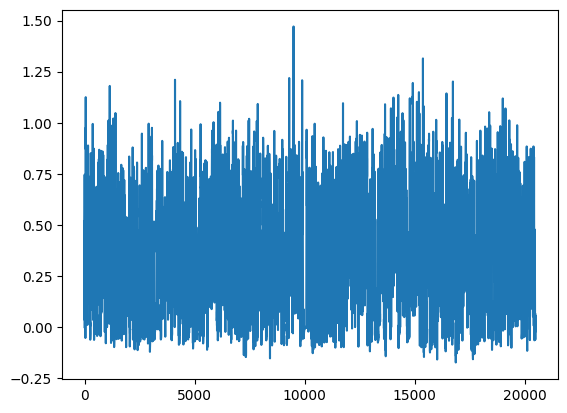

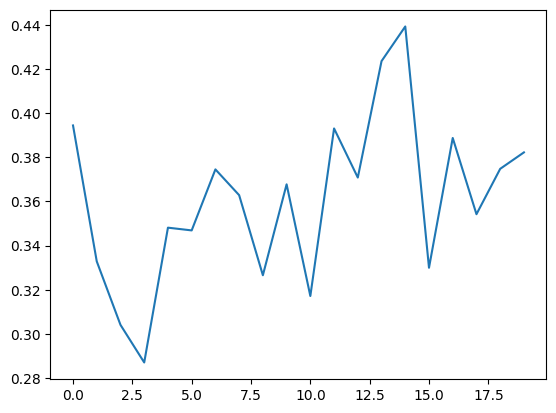

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=132.0638, Policy=0.0130, Value=264.1888
[PPO] Epoch 10: Loss=57.7474, Policy=-0.0066, Value=115.5946
[PPO] Epoch 20: Loss=30.0018, Policy=-0.0269, Value=60.1437
[PPO] Epoch 30: Loss=14.8287, Policy=-0.0443, Value=29.8299
Approx KL Learned: 0.05675077438354492
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=130.8630, Policy=0.0126, Value=261.7883
[PPO] Epoch 10: Loss=56.9594, Policy=0.0035, Value=114.0001
[PPO] Epoch 20: Loss=32.9188, Policy=-0.0213, Value=65.9662
[PPO] Epoch 30: Loss=17.2245, Policy=-0.0383, Value=34.6107
Approx KL Learned: 0.03129877150058746
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=122.7416, Policy=0.0113, Value=245.5503
[PPO] Epoch 10: Loss=60.5967, Policy=0.0043, Value=121.2736
[PPO] Epoch 20: Loss=32.1561, Policy=-0.0160, Value=64.4326
[PPO] Epoch 30: Loss=19.2043, Policy=-0.0318, Value=38.5610
Approx KL Learned: 0.021852480247616768
[✅] Actor-Critic 

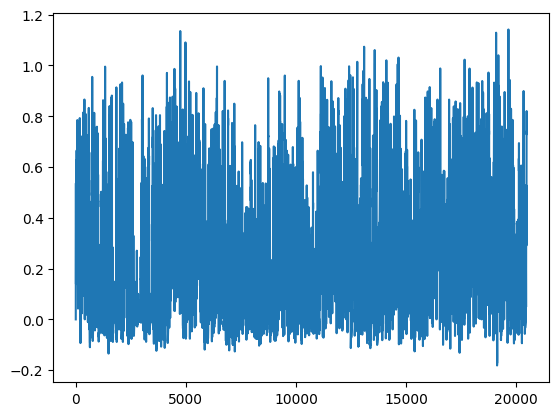

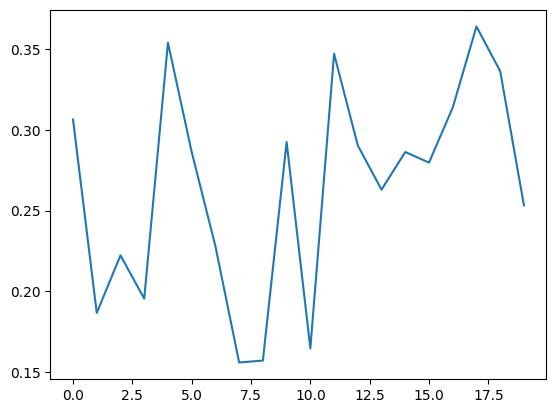

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=100.8811, Policy=0.0110, Value=201.8129
[PPO] Epoch 10: Loss=50.8929, Policy=-0.0034, Value=101.8716
[PPO] Epoch 20: Loss=32.0339, Policy=-0.0287, Value=64.2046
[PPO] Epoch 30: Loss=19.0006, Policy=-0.0410, Value=38.1636
Approx KL Learned: 0.06998205184936523
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=105.7760, Policy=0.0080, Value=211.6185
[PPO] Epoch 10: Loss=52.4710, Policy=0.0137, Value=104.9885
[PPO] Epoch 20: Loss=32.4246, Policy=-0.0069, Value=64.9471
[PPO] Epoch 30: Loss=17.4344, Policy=-0.0270, Value=35.0040
Approx KL Learned: 0.038530364632606506
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=77.3435, Policy=0.0080, Value=154.7494
[PPO] Epoch 10: Loss=51.0171, Policy=-0.0108, Value=102.1323
[PPO] Epoch 20: Loss=35.5415, Policy=-0.0242, Value=71.2097
[PPO] Epoch 30: Loss=21.4829, Policy=-0.0355, Value=43.1149
Approx KL Learned: 0.0359596386551857
[✅] Actor-Critic c

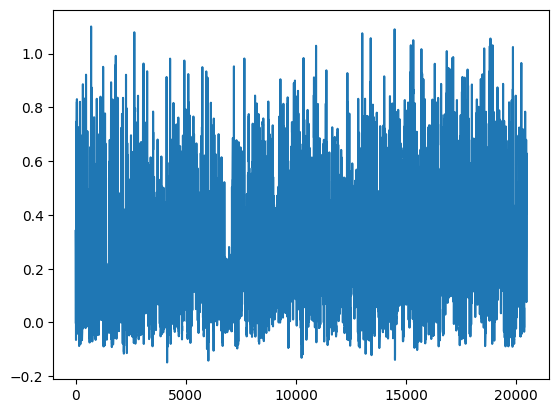

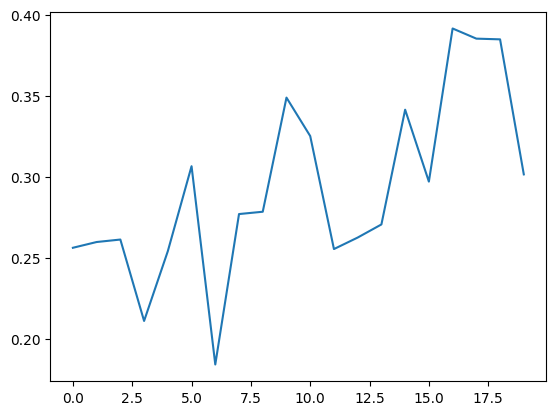

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=91.7902, Policy=0.0067, Value=183.6462
[PPO] Epoch 10: Loss=53.3556, Policy=-0.0075, Value=106.8038
[PPO] Epoch 20: Loss=39.4943, Policy=-0.0180, Value=79.1029
[PPO] Epoch 30: Loss=27.1815, Policy=0.0129, Value=54.4014
Approx KL Learned: 0.09229375422000885
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=55.9208, Policy=0.0103, Value=111.8876
[PPO] Epoch 10: Loss=28.1097, Policy=-0.0136, Value=56.3087
[PPO] Epoch 20: Loss=18.4939, Policy=-0.0213, Value=37.0972
[PPO] Epoch 30: Loss=12.9525, Policy=-0.0378, Value=26.0450
Approx KL Learned: 0.04587192088365555
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=28.9787, Policy=0.0029, Value=58.0093
[PPO] Epoch 10: Loss=18.3120, Policy=-0.0198, Value=36.7162
[PPO] Epoch 20: Loss=12.4598, Policy=-0.0357, Value=25.0490
[PPO] Epoch 30: Loss=8.6449, Policy=-0.0537, Value=17.4539
Approx KL Learned: 0.06933064758777618
[✅] Actor-Critic checkpo

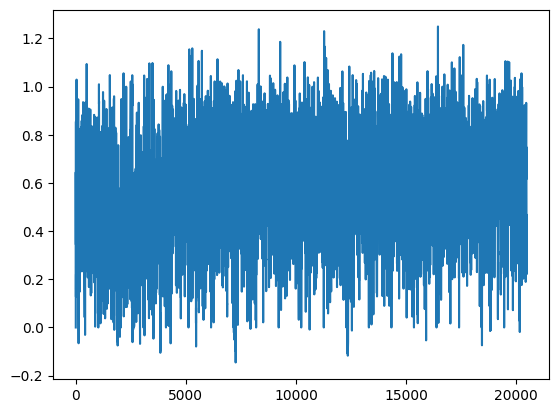

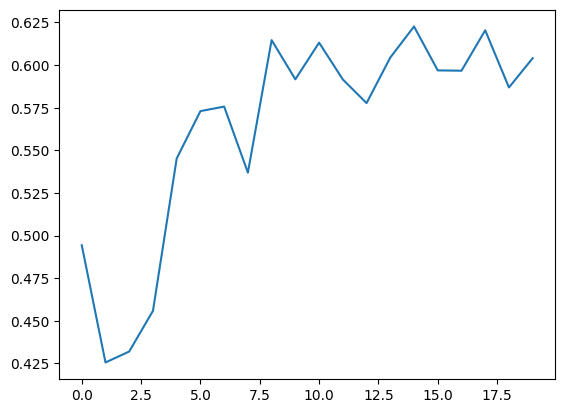

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=110.0117, Policy=0.0050, Value=220.1014
[PPO] Epoch 10: Loss=49.5815, Policy=0.0061, Value=99.2361
[PPO] Epoch 20: Loss=32.7570, Policy=-0.0140, Value=65.6274
[PPO] Epoch 30: Loss=22.3463, Policy=-0.0293, Value=44.8383
Approx KL Learned: 0.027536291629076004
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=108.5277, Policy=0.0112, Value=217.1165
[PPO] Epoch 10: Loss=50.9171, Policy=-0.0094, Value=101.9399
[PPO] Epoch 20: Loss=25.8683, Policy=-0.0305, Value=51.8829
[PPO] Epoch 30: Loss=15.5897, Policy=-0.0427, Value=31.3496
Approx KL Learned: 0.04672030359506607
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=110.5913, Policy=0.0077, Value=221.2500
[PPO] Epoch 10: Loss=62.5290, Policy=-0.0059, Value=125.1509
[PPO] Epoch 20: Loss=41.0437, Policy=-0.0193, Value=82.2072
[PPO] Epoch 30: Loss=24.9133, Policy=-0.0277, Value=49.9635
Approx KL Learned: 0.03568635880947113
[✅] Actor-Critic 

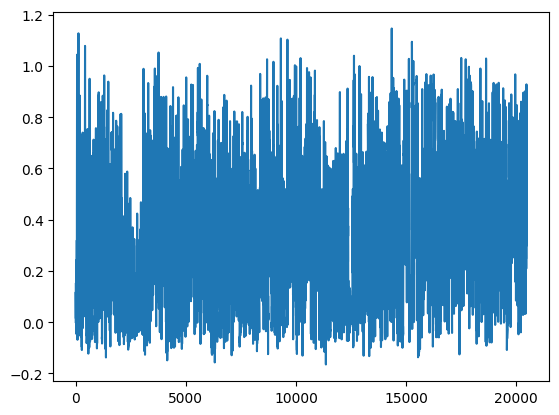

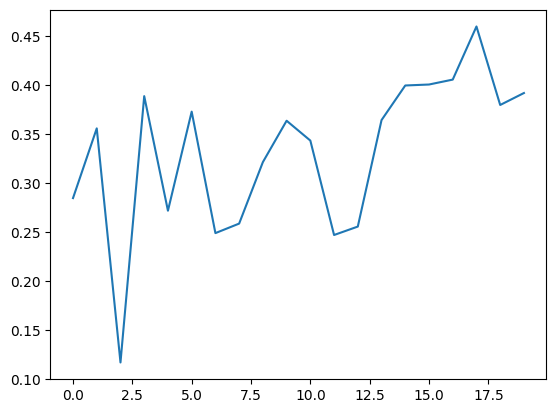

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=84.3563, Policy=0.0074, Value=168.7847
[PPO] Epoch 10: Loss=45.5431, Policy=-0.0085, Value=91.1891
[PPO] Epoch 20: Loss=28.1092, Policy=-0.0226, Value=56.3507
[PPO] Epoch 30: Loss=21.7107, Policy=-0.0357, Value=43.5749
Approx KL Learned: 0.04556123912334442
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=90.7355, Policy=0.0080, Value=181.5384
[PPO] Epoch 10: Loss=40.8204, Policy=-0.0068, Value=81.7364
[PPO] Epoch 20: Loss=24.7327, Policy=-0.0225, Value=49.5928
[PPO] Epoch 30: Loss=16.1012, Policy=-0.0385, Value=32.3611
Approx KL Learned: 0.029359355568885803
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=44.1358, Policy=0.0105, Value=88.3254
[PPO] Epoch 10: Loss=29.2541, Policy=-0.0047, Value=58.5863
[PPO] Epoch 20: Loss=20.1468, Policy=0.0054, Value=40.3506
[PPO] Epoch 30: Loss=15.2468, Policy=-0.0199, Value=30.6088
Approx KL Learned: 0.048930730670690536
[✅] Actor-Critic check

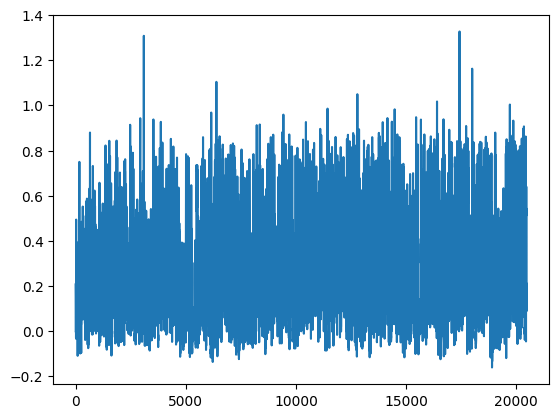

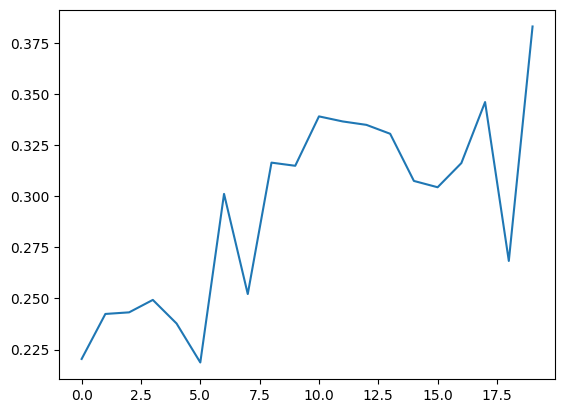

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=77.7742, Policy=0.0017, Value=155.6488
[PPO] Epoch 10: Loss=47.4250, Policy=-0.0029, Value=94.9558
[PPO] Epoch 20: Loss=25.3561, Policy=-0.0241, Value=50.8621
[PPO] Epoch 30: Loss=14.8152, Policy=-0.0301, Value=29.7919
Approx KL Learned: 0.05033128336071968
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=88.6123, Policy=0.0045, Value=177.3181
[PPO] Epoch 10: Loss=57.4913, Policy=-0.0027, Value=115.0858
[PPO] Epoch 20: Loss=43.3955, Policy=-0.0214, Value=86.9333
[PPO] Epoch 30: Loss=30.7686, Policy=-0.0312, Value=61.6988
Approx KL Learned: 0.01958373934030533
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=54.2573, Policy=0.0056, Value=108.6047
[PPO] Epoch 10: Loss=44.6136, Policy=-0.0092, Value=89.3413
[PPO] Epoch 20: Loss=32.2520, Policy=-0.0199, Value=64.6397
[PPO] Epoch 30: Loss=33.1442, Policy=-0.0250, Value=66.4371
Approx KL Learned: 0.16103583574295044
[✅] Actor-Critic chec

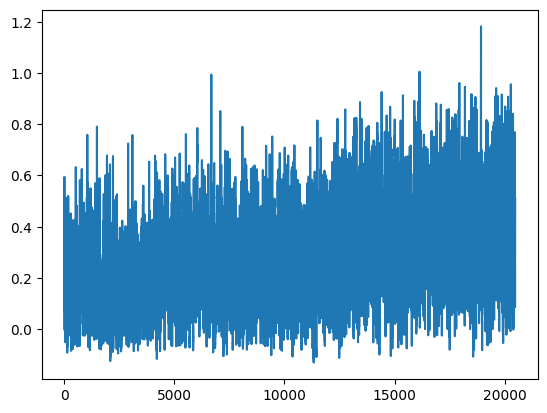

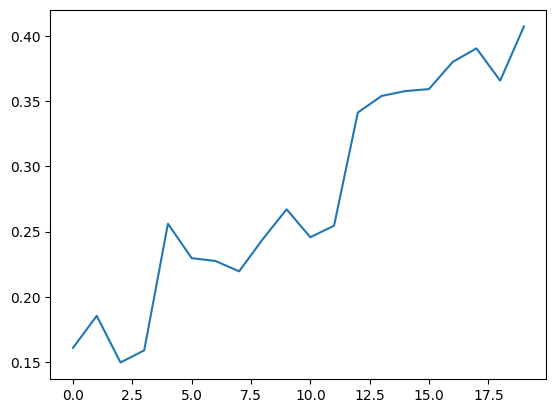

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=131.7099, Policy=0.0041, Value=263.5029
[PPO] Epoch 10: Loss=70.4680, Policy=-0.0041, Value=141.0366
[PPO] Epoch 20: Loss=42.7184, Policy=-0.0139, Value=85.5546
[PPO] Epoch 30: Loss=22.4902, Policy=-0.0246, Value=45.1213
Approx KL Learned: 0.019732657819986343
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=104.0703, Policy=0.0025, Value=208.2321
[PPO] Epoch 10: Loss=58.5473, Policy=-0.0047, Value=117.1997
[PPO] Epoch 20: Loss=39.0407, Policy=-0.0153, Value=78.2082
[PPO] Epoch 30: Loss=27.7029, Policy=-0.0243, Value=55.5505
Approx KL Learned: 0.022827759385108948
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=84.0285, Policy=0.0084, Value=168.1331
[PPO] Epoch 10: Loss=52.4231, Policy=-0.0014, Value=104.9398
[PPO] Epoch 20: Loss=30.7283, Policy=-0.0191, Value=61.5851
[PPO] Epoch 30: Loss=17.7813, Policy=-0.0296, Value=35.7124
Approx KL Learned: 0.08172782510519028
[✅] Actor-Criti

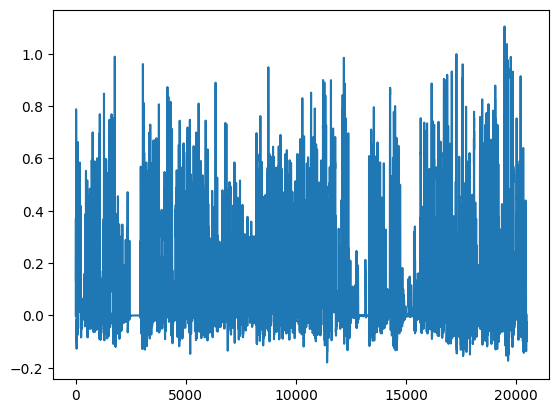

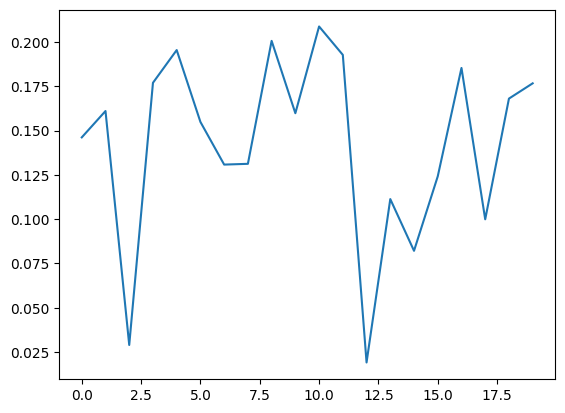

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=132.5637, Policy=0.0096, Value=265.1904
[PPO] Epoch 10: Loss=73.5177, Policy=-0.0015, Value=147.1242
[PPO] Epoch 20: Loss=45.3613, Policy=-0.0159, Value=90.8402
[PPO] Epoch 30: Loss=26.4845, Policy=-0.0326, Value=53.1208
Approx KL Learned: 0.04742826148867607
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=127.5973, Policy=0.0127, Value=255.2556
[PPO] Epoch 10: Loss=70.9047, Policy=0.0035, Value=141.8917
[PPO] Epoch 20: Loss=40.7598, Policy=-0.0116, Value=81.6322
[PPO] Epoch 30: Loss=22.0435, Policy=-0.0272, Value=44.2290
Approx KL Learned: 0.04189030081033707
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=117.5490, Policy=0.0109, Value=235.1663
[PPO] Epoch 10: Loss=70.8555, Policy=0.0009, Value=141.7980
[PPO] Epoch 20: Loss=45.0011, Policy=-0.0155, Value=90.1249
[PPO] Epoch 30: Loss=24.0907, Policy=-0.0293, Value=48.3305
Approx KL Learned: 0.03893972933292389
[✅] Actor-Critic c

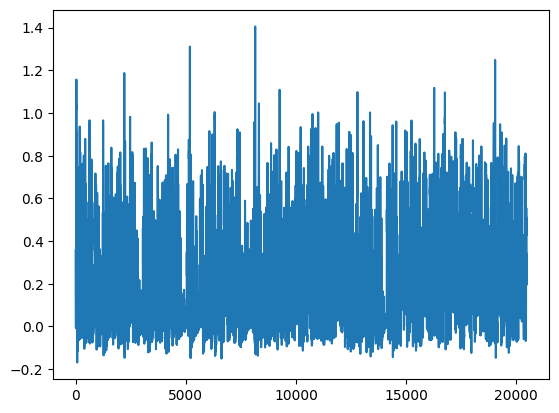

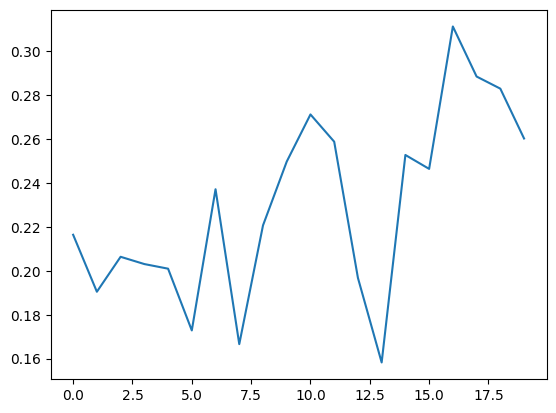

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=133.6712, Policy=0.0117, Value=267.4173
[PPO] Epoch 10: Loss=60.7607, Policy=-0.0027, Value=121.6256
[PPO] Epoch 20: Loss=33.2081, Policy=-0.0235, Value=66.5606
[PPO] Epoch 30: Loss=19.5868, Policy=-0.0401, Value=39.3513
Approx KL Learned: 0.035184890031814575
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=107.2362, Policy=0.0076, Value=214.5534
[PPO] Epoch 10: Loss=49.0614, Policy=-0.0077, Value=98.2336
[PPO] Epoch 20: Loss=26.3973, Policy=-0.0209, Value=52.9321
[PPO] Epoch 30: Loss=13.8031, Policy=-0.0437, Value=27.7874
Approx KL Learned: 0.03289029374718666
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=94.6042, Policy=0.0078, Value=189.2872
[PPO] Epoch 10: Loss=55.9932, Policy=0.0170, Value=112.0446
[PPO] Epoch 20: Loss=36.0940, Policy=-0.0035, Value=72.2871
[PPO] Epoch 30: Loss=21.0398, Policy=-0.0131, Value=42.1992
Approx KL Learned: 0.019642656669020653
[✅] Actor-Critic 

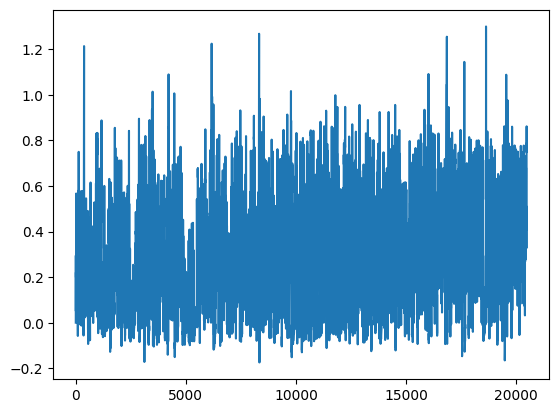

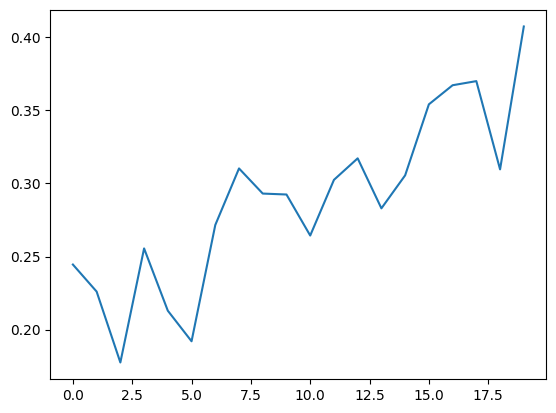

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=101.5549, Policy=0.0097, Value=203.1799
[PPO] Epoch 10: Loss=42.2503, Policy=-0.0090, Value=84.6078
[PPO] Epoch 20: Loss=25.1969, Policy=-0.0319, Value=50.5460
[PPO] Epoch 30: Loss=14.5584, Policy=-0.0342, Value=29.2733
Approx KL Learned: 0.13582290709018707
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=74.3312, Policy=0.0063, Value=148.7414
[PPO] Epoch 10: Loss=41.1826, Policy=0.0063, Value=82.4435
[PPO] Epoch 20: Loss=18.5270, Policy=-0.0188, Value=37.1796
[PPO] Epoch 30: Loss=12.1499, Policy=-0.0250, Value=24.4391
Approx KL Learned: 0.03359585255384445
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=67.3988, Policy=0.0045, Value=134.8741
[PPO] Epoch 10: Loss=34.5163, Policy=-0.0137, Value=69.1449
[PPO] Epoch 20: Loss=17.1304, Policy=-0.0389, Value=34.4228
[PPO] Epoch 30: Loss=13.2293, Policy=-0.0483, Value=26.6405
Approx KL Learned: 0.042063526809215546
[✅] Actor-Critic chec

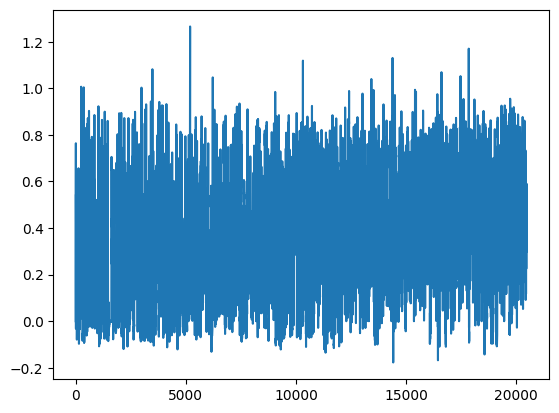

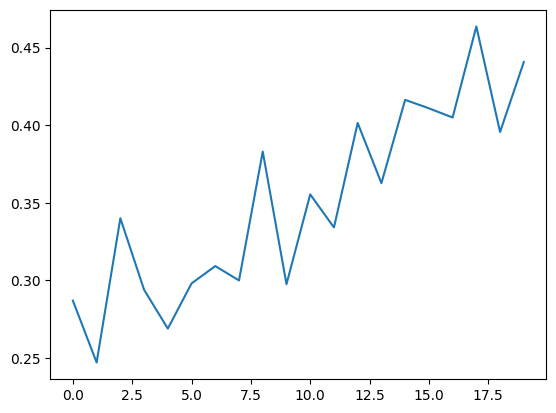

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=100.0671, Policy=0.0081, Value=200.2097
[PPO] Epoch 10: Loss=54.2940, Policy=-0.0028, Value=108.6848
[PPO] Epoch 20: Loss=33.2007, Policy=-0.0205, Value=66.5328
[PPO] Epoch 30: Loss=19.8285, Policy=-0.0330, Value=39.8135
Approx KL Learned: 0.025414802134037018
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=75.8633, Policy=0.0065, Value=151.7990
[PPO] Epoch 10: Loss=44.1929, Policy=-0.0028, Value=88.4773
[PPO] Epoch 20: Loss=24.7629, Policy=-0.0198, Value=49.6486
[PPO] Epoch 30: Loss=17.1031, Policy=-0.0301, Value=34.3486
Approx KL Learned: 0.023164546117186546
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=83.2175, Policy=0.0093, Value=166.4964
[PPO] Epoch 10: Loss=43.1150, Policy=-0.0093, Value=86.3267
[PPO] Epoch 20: Loss=21.5478, Policy=-0.0324, Value=43.2378
[PPO] Epoch 30: Loss=14.8853, Policy=-0.0454, Value=29.9382
Approx KL Learned: 0.028344396501779556
[✅] Actor-Critic 

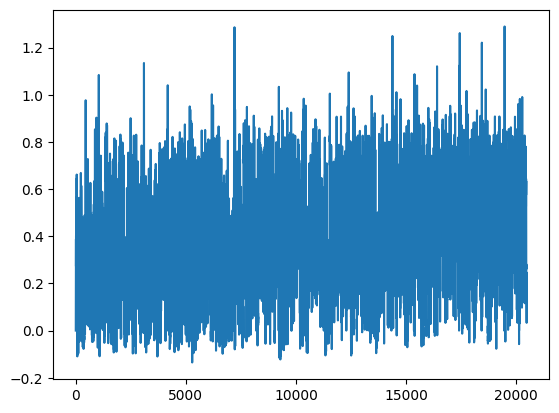

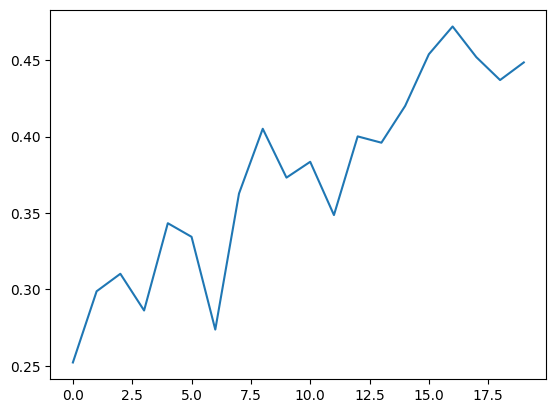

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=105.4762, Policy=0.0042, Value=211.0455
[PPO] Epoch 10: Loss=44.2894, Policy=-0.0091, Value=88.6994
[PPO] Epoch 20: Loss=22.1936, Policy=-0.0283, Value=44.5439
[PPO] Epoch 30: Loss=10.7546, Policy=-0.0450, Value=21.6988
Approx KL Learned: 0.0340946689248085
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=98.0947, Policy=0.0057, Value=196.2770
[PPO] Epoch 10: Loss=61.8316, Policy=-0.0064, Value=123.7722
[PPO] Epoch 20: Loss=34.8696, Policy=-0.0219, Value=69.8794
[PPO] Epoch 30: Loss=20.3673, Policy=-0.0196, Value=40.8699
Approx KL Learned: 0.04689700901508331
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=117.3481, Policy=0.0066, Value=234.7732
[PPO] Epoch 10: Loss=57.2662, Policy=-0.0057, Value=114.6275
[PPO] Epoch 20: Loss=24.8613, Policy=-0.0238, Value=49.8573
[PPO] Epoch 30: Loss=16.1284, Policy=-0.0375, Value=32.4174
Approx KL Learned: 0.02670525200664997
[✅] Actor-Critic ch

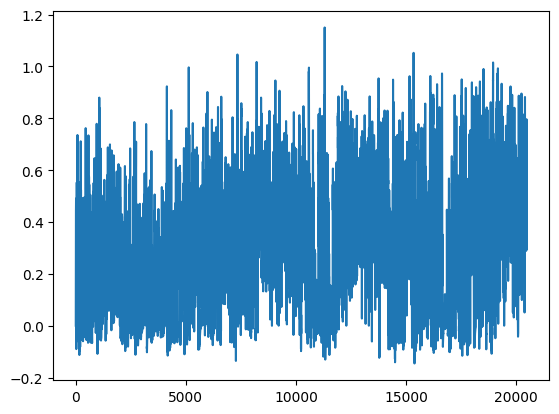

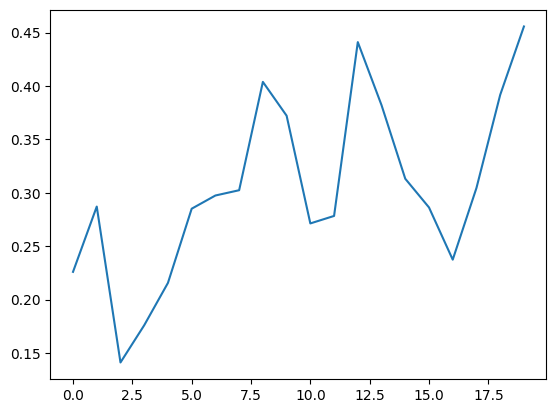

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=88.5149, Policy=0.0141, Value=177.0852
[PPO] Epoch 10: Loss=52.2803, Policy=-0.0065, Value=104.6520
[PPO] Epoch 20: Loss=35.2485, Policy=-0.0170, Value=70.6104
[PPO] Epoch 30: Loss=27.5424, Policy=-0.0236, Value=55.2116
Approx KL Learned: 0.031235406175255775
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=53.9082, Policy=0.0139, Value=107.8689
[PPO] Epoch 10: Loss=35.4478, Policy=0.0017, Value=70.9708
[PPO] Epoch 20: Loss=22.4788, Policy=-0.0126, Value=45.0549
[PPO] Epoch 30: Loss=16.0482, Policy=-0.0329, Value=32.2396
Approx KL Learned: 0.03378798067569733
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=50.7048, Policy=0.0115, Value=101.4617
[PPO] Epoch 10: Loss=25.2034, Policy=-0.0128, Value=50.5020
[PPO] Epoch 20: Loss=15.4941, Policy=-0.0291, Value=31.1165
[PPO] Epoch 30: Loss=9.8311, Policy=-0.0485, Value=19.8296
Approx KL Learned: 0.03338391333818436
[✅] Actor-Critic check

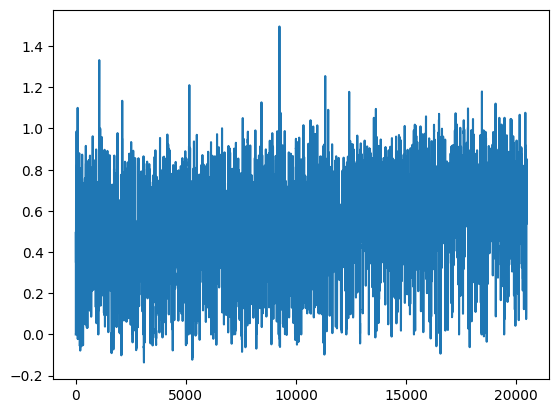

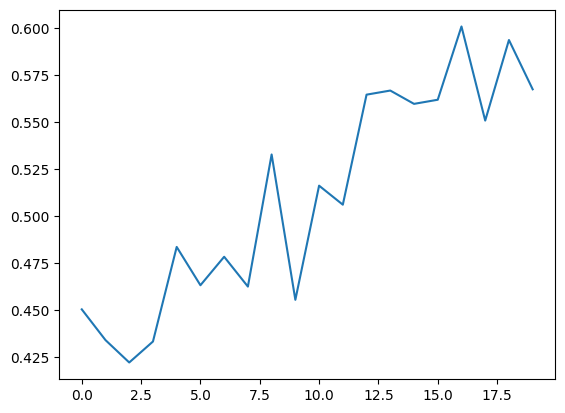

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=90.8862, Policy=0.0114, Value=181.8407
[PPO] Epoch 10: Loss=42.1182, Policy=-0.0039, Value=84.3330
[PPO] Epoch 20: Loss=23.2631, Policy=-0.0191, Value=46.6549
[PPO] Epoch 30: Loss=11.2814, Policy=-0.0461, Value=22.7436
Approx KL Learned: 0.045854128897190094
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=87.5163, Policy=0.0074, Value=175.1007
[PPO] Epoch 10: Loss=43.2719, Policy=-0.0121, Value=86.6478
[PPO] Epoch 20: Loss=24.8284, Policy=-0.0301, Value=49.7958
[PPO] Epoch 30: Loss=15.0408, Policy=-0.0470, Value=30.2547
Approx KL Learned: 0.06547146290540695
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=116.8603, Policy=0.0101, Value=233.8003
[PPO] Epoch 10: Loss=61.6677, Policy=-0.0032, Value=123.4411
[PPO] Epoch 20: Loss=34.6499, Policy=-0.0129, Value=69.4261
[PPO] Epoch 30: Loss=19.1443, Policy=-0.0300, Value=38.4479
Approx KL Learned: 0.02714390680193901
[✅] Actor-Critic ch

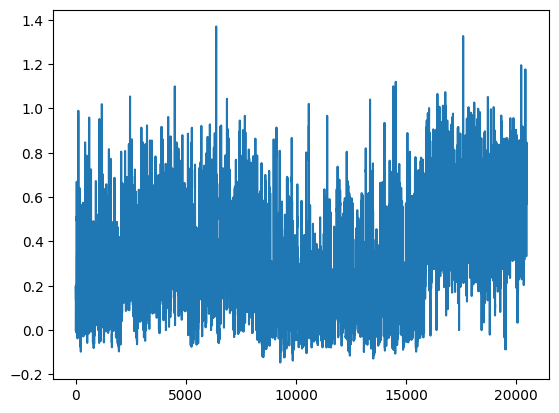

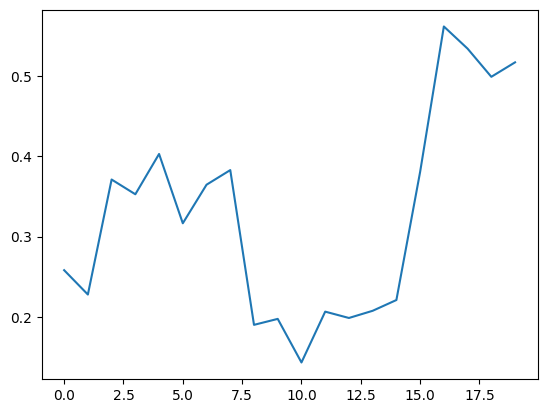

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=110.9151, Policy=0.0110, Value=221.8880
[PPO] Epoch 10: Loss=63.9489, Policy=-0.0050, Value=127.9860
[PPO] Epoch 20: Loss=33.9250, Policy=-0.0205, Value=67.9700
[PPO] Epoch 30: Loss=17.7467, Policy=-0.0344, Value=35.6427
Approx KL Learned: 0.03080700896680355
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=117.1736, Policy=0.0089, Value=234.4121
[PPO] Epoch 10: Loss=57.5268, Policy=-0.0099, Value=115.1541
[PPO] Epoch 20: Loss=28.0610, Policy=-0.0298, Value=56.2624
[PPO] Epoch 30: Loss=16.7393, Policy=-0.0448, Value=33.6486
Approx KL Learned: 0.03521876037120819
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=84.8071, Policy=0.0074, Value=169.6683
[PPO] Epoch 10: Loss=49.6973, Policy=-0.0041, Value=99.4690
[PPO] Epoch 20: Loss=29.1819, Policy=-0.0219, Value=58.4736
[PPO] Epoch 30: Loss=16.6383, Policy=-0.0361, Value=33.4156
Approx KL Learned: 0.042039886116981506
[✅] Actor-Critic 

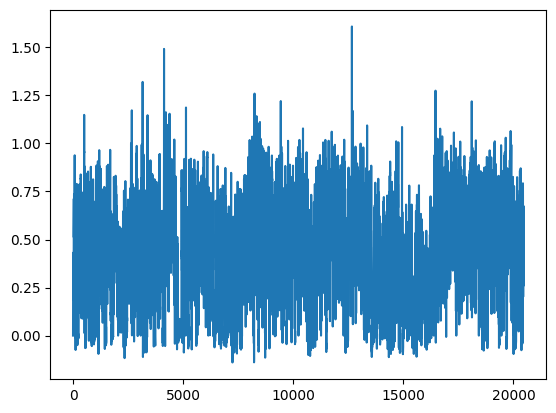

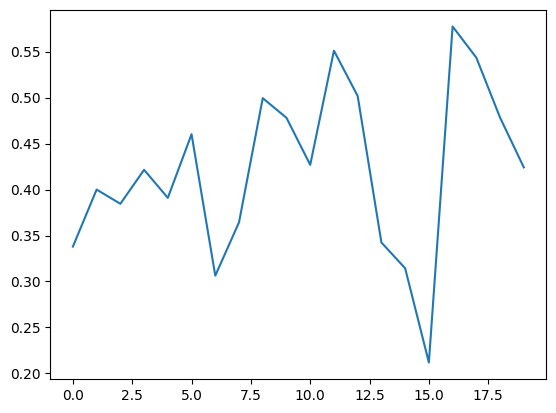

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=96.0595, Policy=0.0102, Value=192.1701
[PPO] Epoch 10: Loss=53.1694, Policy=-0.0033, Value=106.4161
[PPO] Epoch 20: Loss=32.7105, Policy=0.0128, Value=65.4557
[PPO] Epoch 30: Loss=23.1123, Policy=-0.0088, Value=46.3058
Approx KL Learned: 0.047022201120853424
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=75.6435, Policy=0.0089, Value=151.3422
[PPO] Epoch 10: Loss=52.6828, Policy=-0.0061, Value=105.4464
[PPO] Epoch 20: Loss=40.0131, Policy=-0.0159, Value=80.1261
[PPO] Epoch 30: Loss=28.5153, Policy=-0.0242, Value=57.1483
Approx KL Learned: 0.03427303954958916
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=49.7928, Policy=0.0075, Value=99.6388
[PPO] Epoch 10: Loss=28.3800, Policy=-0.0066, Value=56.8425
[PPO] Epoch 20: Loss=19.2794, Policy=-0.0239, Value=38.6722
[PPO] Epoch 30: Loss=13.7446, Policy=-0.0362, Value=27.6271
Approx KL Learned: 0.053559884428977966
[✅] Actor-Critic che

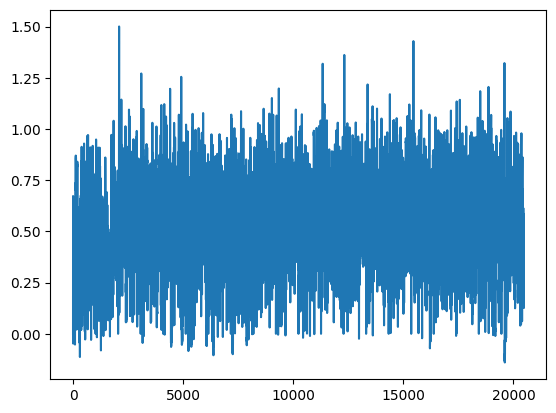

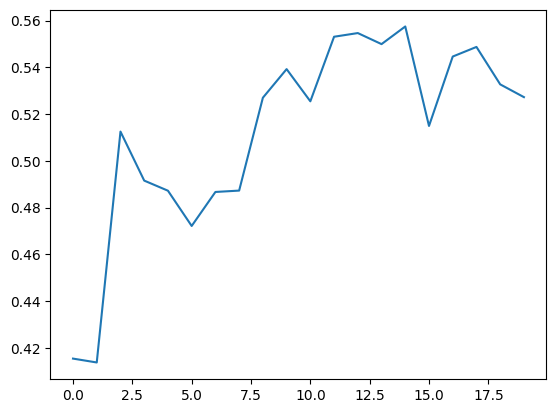

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=79.5168, Policy=0.0073, Value=159.0939
[PPO] Epoch 10: Loss=36.4789, Policy=-0.0102, Value=73.0481
[PPO] Epoch 20: Loss=21.1704, Policy=-0.0268, Value=42.4697
[PPO] Epoch 30: Loss=10.5947, Policy=-0.0175, Value=21.2978
Approx KL Learned: 0.07124534249305725
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=79.1463, Policy=0.0050, Value=158.3522
[PPO] Epoch 10: Loss=44.2898, Policy=-0.0037, Value=88.6534
[PPO] Epoch 20: Loss=30.5073, Policy=-0.0178, Value=61.1150
[PPO] Epoch 30: Loss=23.1255, Policy=-0.0265, Value=46.3709
Approx KL Learned: 0.03196791559457779
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=86.2464, Policy=0.0074, Value=172.5485
[PPO] Epoch 10: Loss=47.2570, Policy=-0.0137, Value=94.6098
[PPO] Epoch 20: Loss=27.4653, Policy=-0.0326, Value=55.0619
[PPO] Epoch 30: Loss=19.1180, Policy=-0.0406, Value=38.3832
Approx KL Learned: 0.03366253525018692
[✅] Actor-Critic check

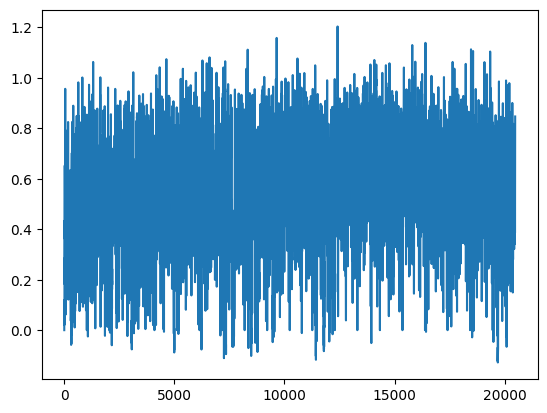

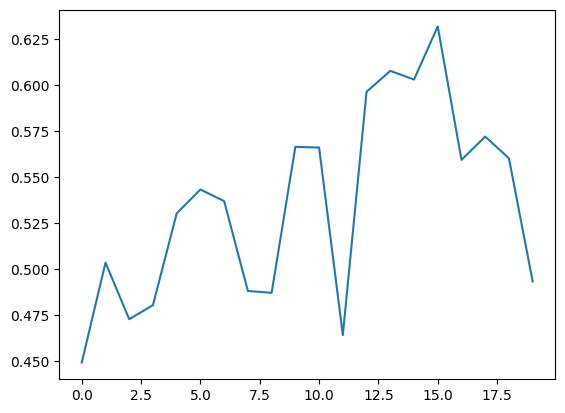

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


[PPO] Epoch 0: Loss=130.3931, Policy=0.0106, Value=260.8676
[PPO] Epoch 10: Loss=65.2787, Policy=-0.0007, Value=130.6614
[PPO] Epoch 20: Loss=47.2711, Policy=-0.0039, Value=94.6495
[PPO] Epoch 30: Loss=25.3660, Policy=0.0165, Value=50.7980
Approx KL Learned: 0.04975712299346924
[✅] Actor-Critic checkpoint saved to weight.pt
Update 1/5 — steps: 4096
[PPO] Epoch 0: Loss=128.1342, Policy=0.0007, Value=256.3688
[PPO] Epoch 10: Loss=56.1399, Policy=-0.0015, Value=112.3803
[PPO] Epoch 20: Loss=33.0971, Policy=-0.0072, Value=66.3083
[PPO] Epoch 30: Loss=20.4067, Policy=-0.0139, Value=40.9411
Approx KL Learned: 0.012775707989931107
[✅] Actor-Critic checkpoint saved to weight.pt
Update 2/5 — steps: 4096
[PPO] Epoch 0: Loss=101.6398, Policy=0.0004, Value=203.3775
[PPO] Epoch 10: Loss=63.1604, Policy=-0.0089, Value=126.4321
[PPO] Epoch 20: Loss=40.6692, Policy=-0.0138, Value=81.4625
[PPO] Epoch 30: Loss=27.6203, Policy=-0.0184, Value=55.3725
Approx KL Learned: 0.013587713241577148
[✅] Actor-Criti

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff38ed46c50>>
Traceback (most recent call last):
  File "/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
from ai2thor.controller import Controller

NUM_ENV = 100
for i in range(NUM_ENV):
    try:
        rand_env = torch.randint(0, len(dataset["train"]), (1,)).item()
        house = dataset["train"][rand_env]
        controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
        teleport(controller)
        buf, rewards, episode_rewards = train(controller, "weight.pt", ppo, clip_env, clip_actor_critic, 5)
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    finally:
        controller.stop()
